# Practical 2: Encoding Sentences with Neural Models

In this practical we will train neural models to encode sentences, after which we can use our sentence representation for a downstream task such as sentiment classification. Rather than simply answering questions, like in the previous lab, **this time you are expected to write a four-page scientific report with your findings**. You will be judged by the quality of your report (see below). In this notebook, we will help you to develop models for your experiments. You do not have to hand in your answers, but please do include a link to a private Github gist with your code in your report as a footnote. 

### Data set
We will make use of the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/) (SST), which provides sentences, their tree structure, and (fine-grained) sentiment scores.
This dataset is different from the one we used in the first practical. 
Before, a review consisted of several sentences, and we would have one sentiment score for it. Now, a review is a single sentence, for which we get a sentiment score. The special thing about our new data set is that we get a binary parse tree for each sentence, and a sentiment score has been assigned to each node in the tree. (We will look at an example below.)

For the first part of this practical we will only make use of the tokens, but in the end we will also exploit the tree-structure that is provided!

We will cover the following approaches:

- Bag-of-words (BOW)
- Continuous bag-of-words (CBOW)
- Deep continuous bag-of-words (Deep CBOW)
- LSTM
- TreeLSTM


### Important: Report 

The main purpose of this lab is for you to learn how to answer research questions by experimenting and then writing a scientific report.
Your grade will be based on the quality of your report, not on the exercises in this notebook.
You can find the requirements for the report at the end of this notebook.

## Preparing the data

Let's first download the data set and take a look.

In [0]:
import re
import random
import time
import math
import numpy as np
import nltk
import matplotlib.pyplot as plt
plt.style.use('default')

In [0]:
!wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
!unzip trainDevTestTrees_PTB.zip

--2018-12-12 14:25:09--  http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip [following]
--2018-12-12 14:25:09--  https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789539 (771K) [application/zip]
Saving to: ‘trainDevTestTrees_PTB.zip.1’

trainDevTestTrees_P 100%[===================>] 771.03K  1.84MB/s    in 0.4s    

2018-12-12 14:25:10 (1.84 MB/s) - ‘trainDevTestTrees_PTB.zip.1’ saved [789539/789539]

Archive:  trainDevTestTrees_PTB.zip
replace trees/dev.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# this function reads in a textfile and fixes an issue with \\
def filereader(path): 
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

In [0]:
# Let's look at a data point.
# If you look closely you will find that this is a flattened tree, 
# with sentiment scores at every node, and words as the leaves.
s = next(filereader("trees/dev.txt"))
print(s)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


In [0]:
# We can use NLTK to print the tree structure more nicely
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

You can see the sentiment annotations here **at every node**! 0 is very negative, 4 is very positive. For now, we will only use the sentiment score at the **root node**; this is the score for the complete sentence.

> Indented block



In [0]:
# Let's first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()
 
# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
13


> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [0]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

In [0]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


You can see that this data set is not very large! That's probably because it required so much manual annotation. However, it's large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and 
the transitions (explained later).

#Subtrees control

In [0]:
USE_SUBTREE_DATA = False

In [0]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])

   
def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)
  

# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


####Subtrees

In [0]:
def get_subtrees(line): 
  stack=[]
  subtrees=[]
  for c in line:
    if c is not ')':
      stack.append(c)
    else:
      s0 = stack.pop()
      string = s0 + c
      while string.count('(') != string.count(')'):  
        s0 = stack.pop()
        string = s0 + string
      for c0 in string:
        stack.append(c0)
      subtrees.append(string)
  return subtrees
       
        

def examplereader_subtree(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    subtrees = get_subtrees(line)
    for s_tree in subtrees:
      tokens = tokens_from_treestring(line)
      tree = Tree.fromstring(line)  # use NLTK's Tree
      label = int(line[1])
      trans = transitions_from_treestring(line)
      yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)
  


  # Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data_subtree = list(examplereader_subtree("trees/train.txt", lower=LOWER))
  


Let's check out an example object.

In [0]:
example = dev_data[221]
print("First train example:", example) # return the sentence in a flatten tree
print("First train example tokens:", example.tokens) # returns tokens
print("First train example label:",  example.label) # return root note (score)

First train example: Example(tokens=['Travels', 'a', 'fascinating', 'arc', 'from', 'hope', 'and', 'euphoria', 'to', 'reality', 'and', 'disillusionment', '.'], tree=Tree('3', [Tree('3', [Tree('3', [Tree('2', ['Travels']), Tree('3', [Tree('4', [Tree('2', ['a']), Tree('3', [Tree('3', ['fascinating']), Tree('2', ['arc'])])]), Tree('3', [Tree('2', ['from']), Tree('2', [Tree('2', [Tree('4', ['hope']), Tree('2', ['and'])]), Tree('4', ['euphoria'])])])])]), Tree('2', [Tree('2', ['to']), Tree('3', [Tree('2', [Tree('2', ['reality']), Tree('2', ['and'])]), Tree('1', ['disillusionment'])])])]), Tree('2', ['.'])]), label=3, transitions=[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1])
First train example tokens: ['Travels', 'a', 'fascinating', 'arc', 'from', 'hope', 'and', 'euphoria', 'to', 'reality', 'and', 'disillusionment', '.']
First train example label: 3


# INFO ABOUT OUR DATA #

In [0]:
print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


In [0]:
train_0 = 0
train_1 = 0
train_2 = 0
train_3 = 0
train_4 = 0
for tag in train_data:
  if tag.label == 0:
    train_0+=1
  elif tag.label == 1:
    train_1+=1
  elif tag.label == 2:
    train_2+=1
  elif tag.label == 3:
    train_3+=1
  elif tag.label == 4:
    train_4+=1
    
print(train_0, train_1, train_2, train_3, train_4)

1092 2218 1624 2322 1288


In [0]:
train_0 = 0
train_1 = 0
train_2 = 0
train_3 = 0
train_4 = 0
for tag in dev_data:
  if tag.label == 0:
    train_0+=1
  elif tag.label == 1:
    train_1+=1
  elif tag.label == 2:
    train_2+=1
  elif tag.label == 3:
    train_3+=1
  elif tag.label == 4:
    train_4+=1
    
print(train_0, train_1, train_2, train_3, train_4)

139 289 229 279 165


In [0]:
train_0 = 0
train_1 = 0
train_2 = 0
train_3 = 0
train_4 = 0
for tag in test_data:
  if tag.label == 0:
    train_0+=1
  elif tag.label == 1:
    train_1+=1
  elif tag.label == 2:
    train_2+=1
  elif tag.label == 3:
    train_3+=1
  elif tag.label == 4:
    train_4+=1
    
print(train_0, train_1, train_2, train_3, train_4)

279 633 389 510 399


In [0]:
test_data_class =[ 279, 633, 389, 510, 399]
dev_data_class =[ 139, 289, 229, 279, 165]
train_data_class =[ 1092, 2218, 1624, 2322, 1288]



prob_test_data_class =[ 279/2210, 633/2210, 389/2210, 510/2210, 399/2210]
print(prob_test_data_class)
prob_dev_data_class =[ 139/1101, 289/1101, 229/1101, 279/1101, 165/1101]
print(prob_dev_data_class)
prob_train_data_class =[ 1092/8544, 2218/8544, 1624/8544, 2322/8544, 1288/8544]
print(prob_train_data_class)

from scipy import stats



stats.ks_2samp(prob_test_data_class, prob_dev_data_class)

[0.1262443438914027, 0.2864253393665158, 0.17601809954751133, 0.23076923076923078, 0.18054298642533936]
[0.1262488646684832, 0.26248864668483196, 0.20799273387829245, 0.25340599455040874, 0.14986376021798364]
[0.12780898876404495, 0.25959737827715357, 0.1900749063670412, 0.2717696629213483, 0.150749063670412]


Ks_2sampResult(statistic=0.20000000000000007, pvalue=0.9996217060535834)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


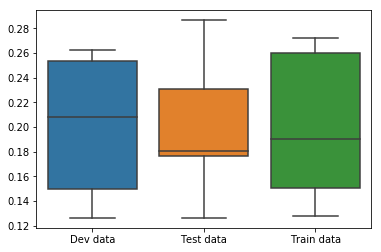

In [0]:
# library & dataset
import seaborn as sns
import pandas as pd


# library & dataset
import seaborn as sns
d = {'Test data': prob_test_data_class, 'Dev data': prob_dev_data_class, 'Train data':prob_train_data_class}
df = pd.DataFrame(data=d)
sns.boxplot(data=df.ix[:,0:3])
#sns.plt.show()



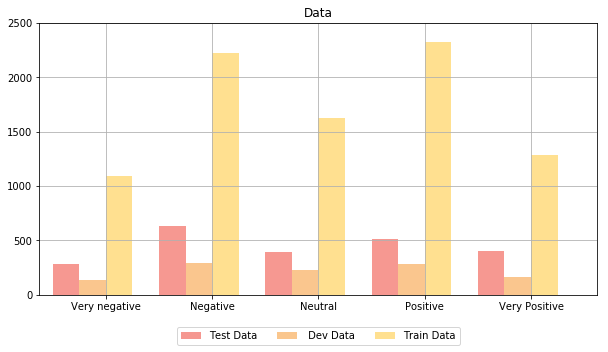

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


raw_data = {'first_name': ['Very negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'],
        'pre_score': [ 279, 633, 389, 510, 399],
        'mid_score': [ 139, 289, 229, 279, 165],
        'post_score': [ 1092, 2218, 1624, 2322, 1288]}
df = pd.DataFrame(raw_data, columns = ['first_name', 'pre_score', 'mid_score', 'post_score'])

# Setting the positions and width for the bars
pos = list(range(len(df['pre_score']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df['pre_score'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=df['first_name'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df['mid_score'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label=df['first_name'][1]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        df['post_score'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the third value in first_name
        label=df['first_name'][2]) 

# Set the y axis label
ax.set_ylabel('')

# Set the chart's title
ax.set_title('Data')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['first_name'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

# Adding the legend and showing the plot
plt.legend(['Test Data', ' Dev Data', 'Train Data'],loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.grid()

plt.ylim(0, 2500)



plt.show()


# Vocabulary 
To work with this data we will need a vocabulary.
The job of the vocabulary is to map each word to a unique ID.


In [0]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

# WORD -->  ID (UNIC) and back (1 on 1 function)

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""
  
  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1
    
  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)    
    
  def build(self, min_freq=0):
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)   
    
    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

Let's build the token vocabulary!

When randomly initializing word vectors, we take the words in our training
set and assign them unique IDs, and assign all other words to <unk>, 
because those we cannot learn a vector for based on our training data.


In [0]:
# This process should be deterministic and should have the same result 
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))


Vocabulary size: 18280


Let's have a closer look at the properties of our vocabulary. Having a good idea of what it is like can facilitate data analysis and debugging later on.

In [0]:
# What is the ID for "century?"
print(v.w2i['century']) # w2i -> convert words to id
print(v.w2i.get('century', 0))

1973
1973


In [0]:
# What are the first 10 words in the vocabulary?
print(v.i2w[:10])

['<unk>', '<pad>', '.', ',', 'the', 'and', 'a', 'of', 'to', "'s"]


In [0]:
# What are the 10 most common words?
print(v.freqs.most_common(10))

[('.', 8024), (',', 7131), ('the', 6037), ('and', 4431), ('a', 4403), ('of', 4386), ('to', 2995), ("'s", 2544), ('is', 2536), ('that', 1915)]


In [0]:
# And how many words are there with frequency 1?
count = 0
for words in v.freqs: # v.freqs : returns the frequency of every word
    if v.freqs[words] == 1:
        count+=1
        
print(count)

9543


In [0]:
# Finally 20 random words from the vocabulary.
# This is a simple way to get a feeling for the data.

from random import randint
random_words = list()
for i in range(0,20):
    random_words.append(v.i2w[randint(0, len(v.i2w))]) 

print(random_words)

['East-vs', 'Germany', 'gain', 'Those', 'Feel', 'Debrauwer', 'timeless', 'condescending', 'hopefully', 'previous', 'intimidated', 'Breaking', 'aside', 'wildest', 'prevention', 'plod', 'cling', 'started', 'collegiate', 'frightening']


#### Sentiment label vocabulary

In [0]:
# Now let's map the sentiment labels 0-4 to a more readable form

# Anothere Function: from id -> target

i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
i2t

['very negative', 'negative', 'neutral', 'positive', 'very positive']

In [0]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})
t2i

OrderedDict([('very negative', 0),
             ('negative', 1),
             ('neutral', 2),
             ('positive', 3),
             ('very positive', 4)])

## Installing PyTorch

We are going to need PyTorch and Google Colab does not have it installed by default. Run the cell below to install it.

*For installing PyTorch in your own computer, follow the instructions on [pytorch.org](pytorch.org) instead. This is for Google Colab only.*

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
from torch import optim
from torch import nn

In [0]:
# this should result in the PyTorch version
torch.__version__

'0.4.1'

In [0]:
# PyTorch can run on CPU or on Nvidia GPU (video card) using CUDA
# This cell selects the GPU if one is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
torch.manual_seed(0)

# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


# SAVE DATA#

In [0]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
def save_data(data, filename):
  from google.colab import auth
  auth.authenticate_user()

  from googleapiclient.discovery import build
  drive_service = build('drive', 'v3')

  # Create a local file to upload.
  with open('/tmp/to_upload.txt', 'w') as f:
    f.write(str(data))

  print('/tmp/to_upload.txt contains:')
  !cat /tmp/to_upload.txt

  from googleapiclient.http import MediaFileUpload

  file_metadata = {
    'name': filename,
    'mimeType': 'text/plain'
  }
  media = MediaFileUpload('/tmp/to_upload.txt', 
                          mimetype='text/plain',
                          resumable=True)
  created = drive_service.files().create(body=file_metadata,
                                         media_body=media,
                                         fields='id').execute()
  print('File ID: {}'.format(created.get('id')))

In [0]:
## HOW YOU SAVE THE DATA ##

# save_data(bow_losses, 'bow_losses_1.txt')
# save_data(bow_accuracies, 'bow_accuracies_1.txt')

## HOW YOU GET THE DATA ##

# with open('/gdrive/My Drive/bow_losses_1.txt', 'r') as f:
#      test = eval(f.read())

# BOW

Our first model is a super simple neural **bag-of-words (BOW) model**.
Unlike the bag-of-words model that you used in the previous lab, here we associate each word with a vector of size 5, exactly our number of sentiment classes. 

To make a classification, we simply **sum** the vectors of the words in our sentence and a bias vector. Because we sum the vectors, we lose word order: that's why we call this a neural bag-of-words model.

```
this   [0.0, 0.1, 0.1, 0.1, 0.0]
movie  [0.1, 0.1, 0.1, 0.2, 0.1]
is     [0.0, 0.1, 0.0, 0.0, 0.0]
stupid [0.9, 0.5, 0.1, 0.0, 0.0]

bias   [0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
sum    [0.9, 0.8, 0.3, 0.3, 0.1]

argmax: 0 (very negative)
```

Now, the **argmax** of this sum is our predicted label.

We initialize all vectors *randomly* and train them using cross-entropy loss.

*Summury: BoW turn each word of the review into a vector of seze 5. then sum all these vector words of the review, plus a bias, and get the outcome vector. By taking the argmax of the vector, you have your prediction! *

*Negatives: Lose word order *

#### Model class

In [0]:
class BOW(nn.Module):
  """A simple bag-of-words model"""

  def __init__(self, vocab_size, embedding_dim, vocab):
    super(BOW, self).__init__()
    self.vocab = vocab
    
    # this is a trained look-up table with word embeddings
    self.embed = nn.Embedding(vocab_size, embedding_dim)
    
    # this is a trained bias term, it will go the last layer, the embedding_dim
    self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)        

  def forward(self, inputs):
    # this is the forward pass of the neural network
    # given inputs, it computes the output

    # this looks up the embeddings for each word ID in inputs
    # the result is a sequence of word embeddings
    embeds = self.embed(inputs)
    
    # the output is the sum across the time dimension (1)
    # with the bias term added
    logits = embeds.sum(1) + self.bias

    return logits

In [0]:
# Let's create a model.
vocab_size = len(v.w2i) # amound of unic word ids = amound of words
n_classes = len(t2i) # number of classes that we want to map
bow_model = BOW(vocab_size, n_classes, v) # the embedding_dim will actually be the number of classes here
print(bow_model)

BOW(
  (embed): Embedding(18280, 5)
)


> **Hey, wait, where is the bias vector?**
> PyTorch does not print Parameters, only Modules!

> We can print it ourselves though, to check that it is there.

In [0]:

# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal parameters: {}\n".format(total))
    

print_parameters(bow_model)

bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total parameters: 91405



#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us. With these IDs we index the word embedding table. 

In [0]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for 1 example
  """
  
  # vocab returns 0 if the word is not there
  x = [vocab.w2i.get(t, 0) for t in example.tokens]
  
  x = torch.LongTensor([x])
  x = x.to(device)
  
  y = torch.LongTensor([example.label])
  y = y.to(device)
 
  
  return x, y

#### Evaluation
We will need one more thing: an evaluation metric.
How many predictions do we get right? The accuracy will tell us.
Make sure that you understand this code block.


In [0]:

def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
  """Accuracy of a model on given data set."""
  correct = 0
  total = 0
  model.eval()  # disable dropout (explained later) -> because we want to evaluate, we want a full connected NN that every node is active

  for example in data:
    
    # convert the example input and label to PyTorch tensors
    x, target = prep_fn(example, model.vocab)

    # forward pass
    # get the output from the neural network for input x
    with torch.no_grad():
      logits = model(x)
    
    # get out the prediction
    prediction = logits.argmax(dim=-1)
    
    # add the number of correct predictions to the total correct
    correct += (prediction == target).sum().item()
    total += 1
    
  #print(total)

  return correct, total, correct / float(total)


#simple_evaluate(bow_model, train_data)

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this to get validation and test examples, too.

In [0]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  for example in data:
    yield example

#### Exercise: Training function

Your task is now to complete the training loop below.
Before you do so, please read the section about optimization.

**Optimization**

As mentioned in the "Introduction to PyTorch" notebook, one of the perks of using PyTorch are its automatic differentiation abilities. We will use these to train our BOW model. 

We train our model by feeding it an input and performing **forward** pass, which results in an output for which we obtain a **loss** with our loss function.
After the gradients are calculated in the **backward** pass, we can take a step on the loss surface towards more optimal parameter settings (e.g. gradient descent). 

The package we will use to do this optimization is [torch.optim](https://pytorch.org/docs/stable/optim.html). Besides implementations of stochastic gradient descent (SGD), this package also implements the optimization algorithm Adam, which we'll be using in this practical. 
For the purposes of this assignment you do not need to know what Adam does besides that it uses gradient information to update our model parameters by calling: 

```
optimizer.step()
```
Remember when we updated our parameters in the PyTorch tutorial in a loop?


```python
# update weights
learning_rate = 0.5
for f in net.parameters():
    # for each parameter, take a small step in the opposite dir of the gradient
    p.data = p.data - p.grad.data * learning_rate

```
The function call optimizer.step() does effectively the same thing.

*(If you want to know more about optimization algorithms using gradient information [this blog](http://ruder.io/optimizing-gradient-descent/.) gives a nice intuitive overview.)*

In [0]:
def train_model(model, optimizer, num_iterations=10000, 
                print_every=1000, eval_every=1000,
                batch_fn=get_examples, 
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None):
  """Train a model."""  
  iter_i = 0
  train_loss = 0.
  print_num = 0
  start = time.time()
  criterion = nn.CrossEntropyLoss() # loss function
  best_eval = 0.
  best_iter = 0
  
  # store train loss and validation accuracy during training
  # so we can plot them afterwards
  losses = []
  accuracies = []  
  
  if eval_batch_size is None:
    eval_batch_size = batch_size
  
  training_data = train_data
  if(USE_SUBTREE_DATA):
    training_data = train_data_subtree
    
  while True:  # when we run out of examples, shuffle and continue
    for batch in batch_fn(training_data, batch_size=batch_size):

      # forward pass
      model.train()
      x, targets = prep_fn(batch, model.vocab)
      logits = model(x)

      B = targets.size(0)  # later we will use B examples per update
      
      # compute cross-entropy loss (our criterion)
      # note that the cross entropy loss function computes the softmax for us
      loss = criterion(logits.view([B, -1]), targets.view(-1))
      train_loss += loss.item()

      # backward pass
      # Tip: check the Introduction to PyTorch notebook.

      # erase previous gradients
      model.zero_grad()

      # compute gradients
      loss.backward() 

      # update weights - take a small step in the opposite dir of the gradient
      optimizer.step()

      print_num += 1
      iter_i += 1

      # print info
      if iter_i % print_every == 0:
        print("Iter %r: loss=%.4f, time=%.2fs" % 
              (iter_i, train_loss, time.time()-start))
        losses.append(train_loss)
        print_num = 0        
        train_loss = 0.

      # evaluate
      if iter_i % eval_every == 0:
        _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                 batch_fn=batch_fn, prep_fn=prep_fn)
        accuracies.append(accuracy)
        print("iter %r: dev acc=%.4f" % (iter_i, accuracy))       
        
        # save best model parameters
        if accuracy > best_eval:
          print("new highscore")
          best_eval = accuracy
          best_iter = iter_i
          path = "{}.pt".format(model.__class__.__name__)
          ckpt = {
              "state_dict": model.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
              "best_eval": best_eval,
              "best_iter": best_iter
          }
          torch.save(ckpt, path)

      # done training
      if iter_i == num_iterations:
        print("Done training")
        
        # evaluate on train, dev, and test with best model
        print("Loading best model")
        path = "{}.pt".format(model.__class__.__name__)        
        ckpt = torch.load(path)
        model.load_state_dict(ckpt["state_dict"])
        
        _, _, train_acc = eval_fn(
            model, training_data, batch_size=eval_batch_size, 
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, dev_acc = eval_fn(
            model, dev_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, test_acc = eval_fn(
            model, test_data, batch_size=eval_batch_size, 
            batch_fn=batch_fn, prep_fn=prep_fn)
        
        print("best model iter {:d}: "
              "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
                  best_iter, train_acc, dev_acc, test_acc))
        
        return losses, accuracies

### Training the BOW model

In [0]:
# If everything is in place we can now train our first model!

torch.manual_seed(1231)
bow_model = BOW(len(v.w2i), len(t2i), vocab=v)
bow_model = bow_model.to(device)
optimizer = optim.Adam(bow_model.parameters(), lr=0.0005)

bow_losses_1, bow_accuracies_1 = train_model(bow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(bow_losses_1, 'bow_losses_1.txt')
save_data(bow_accuracies_1, 'bow_accuracies_1.txt')


torch.manual_seed(1232)
bow_model = BOW(len(v.w2i), len(t2i), vocab=v)
bow_model = bow_model.to(device)
optimizer = optim.Adam(bow_model.parameters(), lr=0.0005)

bow_losses_2, bow_accuracies_2 = train_model(bow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(bow_losses_2, 'bow_losses_2.txt')
save_data(bow_accuracies_2, 'bow_accuracies_2.txt')


torch.manual_seed(1233)
bow_model = BOW(len(v.w2i), len(t2i), vocab=v)
bow_model = bow_model.to(device)
optimizer = optim.Adam(bow_model.parameters(), lr=0.0005)

bow_losses_3, bow_accuracies_3 = train_model(bow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(bow_losses_3, 'bow_losses_3.txt')
save_data(bow_accuracies_3, 'bow_accuracies_3.txt')

Shuffling training data
Iter 1000: loss=5641.9398, time=1.99s
iter 1000: dev acc=0.2107
new highscore
Iter 2000: loss=4965.2830, time=4.58s
iter 2000: dev acc=0.2125
new highscore
Iter 3000: loss=4851.2470, time=7.21s
iter 3000: dev acc=0.2271
new highscore
Iter 4000: loss=4557.4064, time=9.84s
iter 4000: dev acc=0.2271
Iter 5000: loss=4330.1551, time=12.46s
iter 5000: dev acc=0.2262
Iter 6000: loss=4302.1991, time=15.07s
iter 6000: dev acc=0.2343
new highscore
Iter 7000: loss=4345.9872, time=17.69s
iter 7000: dev acc=0.2407
new highscore
Iter 8000: loss=4458.2311, time=20.32s
iter 8000: dev acc=0.2380
Shuffling training data
Iter 9000: loss=4270.4445, time=22.94s
iter 9000: dev acc=0.2371
Iter 10000: loss=3966.7797, time=25.55s
iter 10000: dev acc=0.2371
Iter 11000: loss=3993.1835, time=28.15s
iter 11000: dev acc=0.2425
new highscore
Iter 12000: loss=4004.3632, time=30.76s
iter 12000: dev acc=0.2416
Iter 13000: loss=3799.6240, time=33.37s
iter 13000: dev acc=0.2407
Iter 14000: loss=37

In [0]:
torch.manual_seed(1231)
bow_model = BOW(len(v.w2i), len(t2i), vocab=v)
bow_model = bow_model.to(device)
optimizer = optim.Adam(bow_model.parameters(), lr=0.0005)

bow_losses, bow_accuracies = train_model(bow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)

Shuffling training data
Iter 1000: loss=6144.9072, time=2.58s
iter 1000: dev acc=0.2116
new highscore
Iter 2000: loss=5624.6757, time=5.63s
iter 2000: dev acc=0.2252
new highscore
Iter 3000: loss=5158.9785, time=8.67s
iter 3000: dev acc=0.2280
new highscore
Iter 4000: loss=5319.4501, time=11.68s
iter 4000: dev acc=0.2271
Iter 5000: loss=4934.9848, time=14.69s
iter 5000: dev acc=0.2280
Iter 6000: loss=4541.8359, time=17.70s
iter 6000: dev acc=0.2325
new highscore
Iter 7000: loss=4843.2454, time=20.72s
iter 7000: dev acc=0.2334
new highscore
Iter 8000: loss=4371.8703, time=23.76s
iter 8000: dev acc=0.2361
new highscore
Iter 9000: loss=4513.6039, time=26.79s
iter 9000: dev acc=0.2389
new highscore
Iter 10000: loss=4233.4899, time=29.82s
iter 10000: dev acc=0.2416
new highscore
Iter 11000: loss=4148.5469, time=32.85s
iter 11000: dev acc=0.2380
Iter 12000: loss=4149.4211, time=35.87s
iter 12000: dev acc=0.2407
Iter 13000: loss=4085.8514, time=38.89s
iter 13000: dev acc=0.2470
new highscore


KeyboardInterrupt: ignored

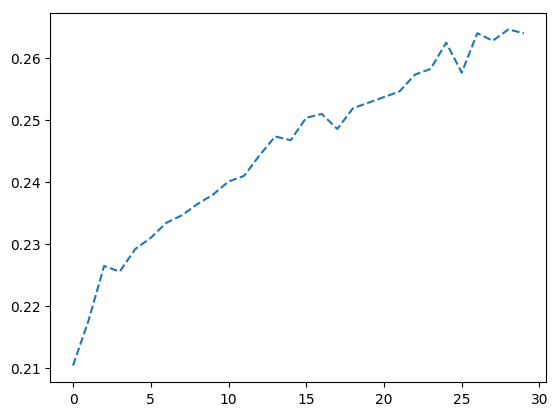

In [0]:
mean_acc_bow = np.mean([bow_accuracies_1, bow_accuracies_2, bow_accuracies_3], axis = 0)
# plt.plot(bow_accuracies_1)
# plt.plot(bow_accuracies_2)
# plt.plot(bow_accuracies_3)
plt.plot(mean_acc_bow, '--')

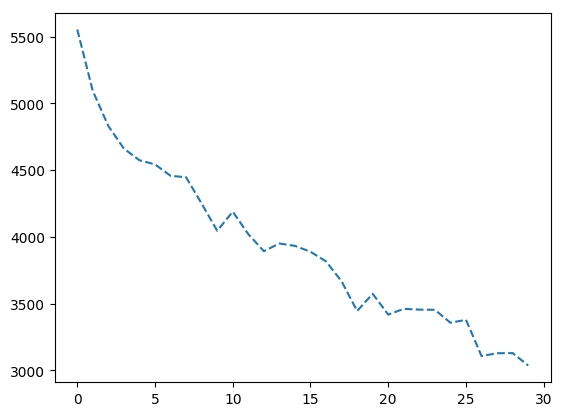

In [0]:
mean_loss_bow = np.mean([bow_losses_1, bow_losses_2, bow_losses_3], axis = 0)
# plt.plot(bow_losses_1)
# plt.plot(bow_losses_2)
# plt.plot(bow_losses_3)
plt.plot(mean_loss_bow, '--')

## Evaluation of BOW ##

In [0]:
mean_accuracy_bow = np.mean([0.2616, 0.2752, 0.2616])
std_accuracy_bow = np.std([0.2616, 0.2752, 0.2616])
print('Mean accuracy of BOW:', mean_accuracy_bow,'STD of BOW:', std_accuracy_bow)

Mean accuracy of BOW: 0.26613333333333333 STD of BOW: 0.006411101482758031


## SUBTREE #

In [0]:
USE_SUBTREE_DATA = True
bow_losses_subtree, bow_accuracies_subtree = train_model(bow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
USE_SUBTREE_DATA = False


Shuffling training data
Iter 1000: loss=3175.1012, time=2.11s
iter 1000: dev acc=0.2843
new highscore
Iter 2000: loss=3399.4500, time=4.64s
iter 2000: dev acc=0.2843
Iter 3000: loss=3206.8555, time=7.14s
iter 3000: dev acc=0.2807
Iter 4000: loss=3082.0140, time=9.62s
iter 4000: dev acc=0.2879
new highscore
Iter 5000: loss=3137.0109, time=12.12s
iter 5000: dev acc=0.2888
new highscore
Iter 6000: loss=3039.4412, time=14.62s
iter 6000: dev acc=0.2861
Iter 7000: loss=3068.0466, time=17.09s
iter 7000: dev acc=0.2925
new highscore
Iter 8000: loss=2916.2088, time=19.57s
iter 8000: dev acc=0.2925
Iter 9000: loss=3022.5463, time=22.07s
iter 9000: dev acc=0.2925
Iter 10000: loss=2947.6308, time=24.56s
iter 10000: dev acc=0.2934
new highscore
Iter 11000: loss=2846.3376, time=27.06s
iter 11000: dev acc=0.2943
new highscore
Iter 12000: loss=2753.5742, time=29.54s
iter 12000: dev acc=0.2961
new highscore
Iter 13000: loss=2732.8214, time=32.01s
iter 13000: dev acc=0.2925
Iter 14000: loss=2689.4777, t

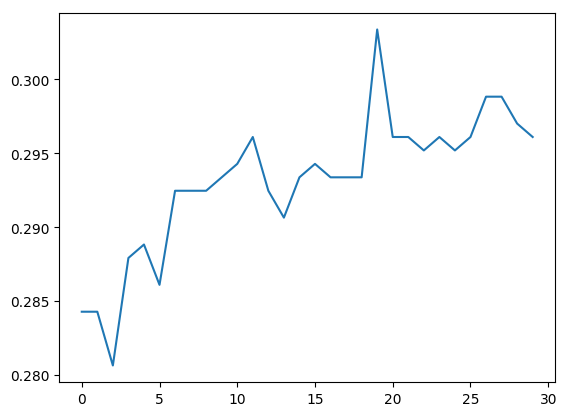

In [0]:
# This will plot the validation accuracies across time for subtrees data. (By time here we mean epochs)
plt.plot(bow_accuracies_subtree);

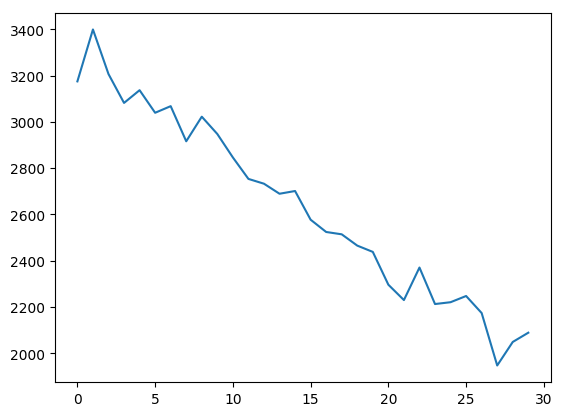

In [0]:
# This will plot the training loss over time for subtrees data.
plt.plot(bow_losses_subtree);

# CBOW

We now continue with a **continuous bag-of-words (CBOW)** model.
It is similar to the BOW model, but now embeddings can have a dimension of *arbitrary size*. 
This means that we can make them bigger and learn more aspects of each word. We will still sum the vectors to get a sentence representation, but now the result is no longer conveniently the number of sentiment classes. 

*Note that this is not the same as word2vec CBOW.* Both models take a few words as input, sum and make a prediction. However, in word2vec the prediction is the word in the middle of the input words. Here, the prediction is a sentiment class (1 out of 5 possible numbers 0-4).

So what can we do? We can *learn* a parameter matrix $W$ that turns our summed vector into the number of output classes, by matrix-multiplying it: $$Wx$$
If the size of $W$ is `5 x d`, and $x$ is `d x 1` and , then the result will be `5x1`, and then we can again find our prediction using an argmax.

**Summury** 
CBOW extends the  embeddings size. This leads to learn more aspects of each word. Still summing, but vectos are widder

input words -> layer of arbitrary (like 300 nodes) -> 5 layer

(-> 1 node, the argmax #this step take place later)



## Exercise: write CBOW class & train it

Write a class `CBOW` that:

- has word embeddings with size 300
- sums the word vectors for the input words (just like in `BOW`)
- projects the resulting vector down to 5 units using a linear layer (including a bias term)

Train your CBOW model and plot the validation accuracy and training loss over time.

In [0]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, vocab):
        super().__init__()
 
        # this is a trained look-up table with word embeddings
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        
        # adding and full connected layer
        self.fc = nn.Linear(embedding_dim, 5)       
        
        self.vocab = vocab
        embeed = self.embed
   
        # this is a trained bias term
        self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)        
 
    def forward(self, inputs):
        embeds = self.embed(inputs).sum(1) + self.bias
      
        # passing the value to the last layer
        logits = self.fc(embeds)
   
        return logits

In [0]:
# train function

torch.manual_seed(1231)
cbow_model = CBOW(len(v.w2i), 300, vocab=v)
cbow_model = cbow_model.to(device)
optimizer = optim.Adam(cbow_model.parameters(), lr=0.0005)

cbow_losses_1, cbow_accuracies_1 = train_model(cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(cbow_losses_1, 'cbow_losses_1.txt')
save_data(cbow_accuracies_1, 'cbow_accuracies_1.txt')


torch.manual_seed(1232)
cbow_model = CBOW(len(v.w2i), 300, vocab=v)
cbow_model = cbow_model.to(device)
optimizer = optim.Adam(cbow_model.parameters(), lr=0.0005)

cbow_losses_2, cbow_accuracies_2 = train_model(cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(cbow_losses_2, 'cbow_losses_2.txt')
save_data(cbow_accuracies_2, 'cbow_accuracies_2.txt')


torch.manual_seed(1233)
cbow_model = CBOW(len(v.w2i), 300, vocab=v)
cbow_model = cbow_model.to(device)
optimizer = optim.Adam(cbow_model.parameters(), lr=0.0005)

cbow_losses_3, cbow_accuracies_3 = train_model(cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(cbow_losses_3, 'cbow_losses_3.txt')
save_data(cbow_losses_3, 'cbow_losses_3.txt')

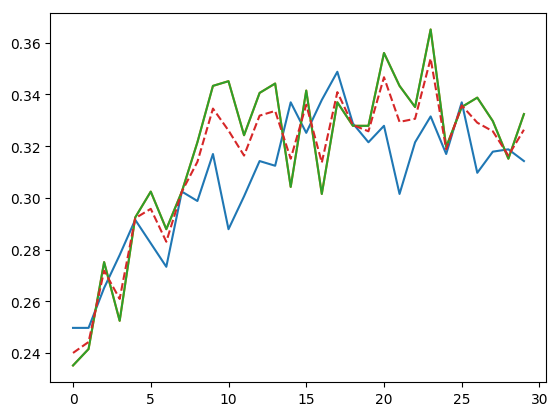

In [0]:
mean_acc_cbow = np.mean([cbow_accuracies_1, cbow_accuracies_2, cbow_accuracies_3], axis = 0)
plt.plot(cbow_accuracies_1)
plt.plot(cbow_accuracies_2)
plt.plot(cbow_accuracies_3)
plt.plot(mean_acc_cbow, '--')

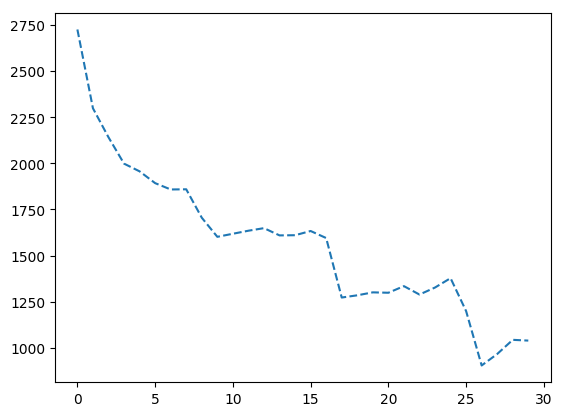

In [0]:
mean_loss_cbow = np.mean([cbow_losses_1, cbow_losses_2, cbow_losses_3], axis = 0)
# plt.plot(cbow_losses_1)
# plt.plot(cbow_losses_2)
# plt.plot(cbow_losses_3)
plt.plot(mean_loss_cbow, '--')

## EVALUATION OF CBOW ##

In [0]:
mean_accuracy_cbow = np.mean([0.3421, 0.3638, 0.3552])
std_accuracy_cbow = np.std([0.3421, 0.3638, 0.3552])
print('Mean accuracy of CBOW:', mean_accuracy_cbow,'STD of CBOW:', std_accuracy_cbow)

Mean accuracy of CBOW: 0.35369999999999996 STD of CBOW: 0.008922256814655508


## SUBTREE ##

In [0]:
USE_SUBTREE_DATA = True
cbow_losses_subtree, cbow_accuracies_subtree = train_model(cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
USE_SUBTREE_DATA = False

Shuffling training data
Iter 1000: loss=903.5811, time=5.73s
iter 1000: dev acc=0.3606
new highscore
Iter 2000: loss=955.9934, time=11.95s
iter 2000: dev acc=0.3606
Iter 3000: loss=1008.2587, time=18.08s
iter 3000: dev acc=0.3606
Iter 4000: loss=951.8291, time=24.17s
iter 4000: dev acc=0.3606
Iter 5000: loss=1022.0646, time=30.29s
iter 5000: dev acc=0.3606
Iter 6000: loss=964.6174, time=36.47s
iter 6000: dev acc=0.3606
Iter 7000: loss=921.7233, time=42.60s
iter 7000: dev acc=0.3606
Iter 8000: loss=924.0503, time=48.71s
iter 8000: dev acc=0.3606
Iter 9000: loss=961.0747, time=54.80s
iter 9000: dev acc=0.3606
Iter 10000: loss=965.7897, time=60.89s
iter 10000: dev acc=0.3606
Iter 11000: loss=915.9060, time=67.08s
iter 11000: dev acc=0.3606
Iter 12000: loss=981.8766, time=73.17s
iter 12000: dev acc=0.3606
Iter 13000: loss=888.9842, time=79.25s
iter 13000: dev acc=0.3606
Iter 14000: loss=902.9269, time=85.36s
iter 14000: dev acc=0.3606
Iter 15000: loss=980.2359, time=91.44s
iter 15000: dev 

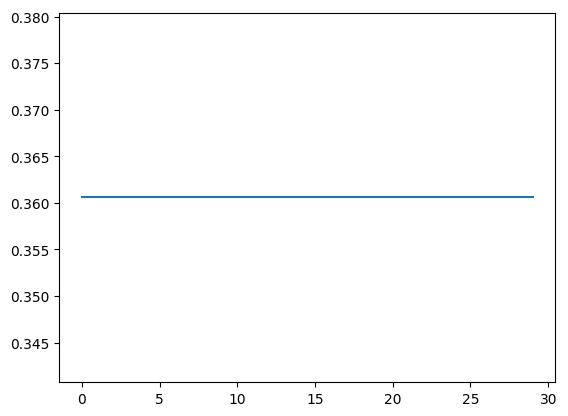

In [0]:
plt.plot(cbow_accuracies_subtree)

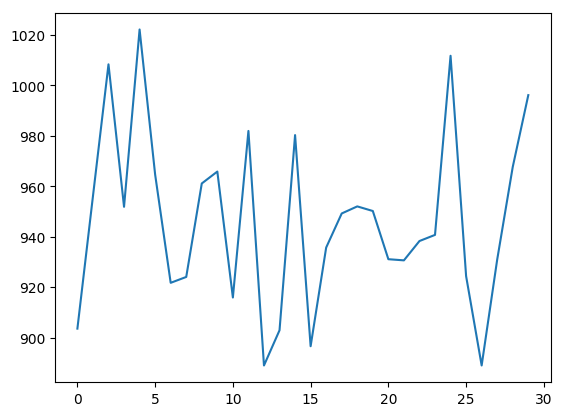

In [0]:
plt.plot(cbow_losses_subtree)

# Deep CBOW

To see if we can squeeze some more performance out of the CBOW model, we can make it deeper and non-linear: add more layers and tanh-activations.
By using more parameters we can learn more aspects of the data, and by using more layers and non-linearities, we can try to learn a more complex function. 
This is not something that always works. If the input-output mapping of your data is simple, then a complicated function could easily overfit on your training set, which will lead to poor generalization. 

We will use E for the size of the word embeddings (use: 300) and D for the size of a hidden layer (use: 100).

#### Exercise: write Deep CBOW class and train it

Write a class `DeepCBOW`.

In your code, make sure that your `output_layer` consists of the following:
- A linear transformation from E units to D units.
- A Tanh activation
- A linear transformation from D units to D units
- A Tanh activation
- A linear transformation from D units to 5 units (our output classes).

We recommend using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?highlight=sequential#torch.nn.Sequential) to implement this exercise.

** Summmury ** 

Same philosofy as CBOW but now we try to make the model better by adding more hidden layers. With this we try to learn more complex functions (basis functions) we try to learn more aspects of the data. This works if we have a complex model, if not there we have overfitting

18280 (vocab_size)- > 300 (embeding_size)-> 100(E) -> 100 (D)-> 5 output

In [0]:
class DeepCBOW(nn.Module):
    """  A simple continuous bag-of-words model """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
        super().__init__()
        self.vocab = vocab
        self.E = embedding_dim
        self.D = 100
        
        # this is a trained look-up table with word embeddings
        self.embed = nn.Embedding(vocab_size, embedding_dim)
              
        # Adding more layers (Deep Network)
        self.seq = nn.Sequential(
              nn.Linear(self.E, self.D),
              nn.Tanh(),
              nn.Linear(self.D, self.D),
              nn.Tanh(),
              nn.Linear(self.D, 5)
        )
   
        # this is a trained bias term
        self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)        
 
    def forward(self, inputs):
        embeds = self.embed(inputs).sum(1) + self.bias
      
        logits = self.seq(embeds)
   
        return logits

In [0]:
# train function

torch.manual_seed(1231)
deep_cbow_model = DeepCBOW(len(v.w2i), 300, 100, len(t2i), vocab=v)
deep_cbow_model = deep_cbow_model.to(device)
optimizer = optim.Adam(deep_cbow_model.parameters(), lr=0.0005)

deep_cbow_losses_1, deep_cbow_accuracies_1 = train_model(deep_cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(deep_cbow_losses_1, 'deep_cbow_losses_1.txt')
save_data(deep_cbow_accuracies_1, 'deep_cbow_accuracies_1.txt')

torch.manual_seed(1232)
deep_cbow_model = DeepCBOW(len(v.w2i), 300, 100, len(t2i), vocab=v)
deep_cbow_model = deep_cbow_model.to(device)
optimizer = optim.Adam(deep_cbow_model.parameters(), lr=0.0005)

deep_cbow_losses_2, deep_cbow_accuracies_2 = train_model(deep_cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(deep_cbow_losses_2, 'deep_cbow_losses_2.txt')
save_data(deep_cbow_accuracies_2, 'deep_cbow_accuracies_2.txt')

torch.manual_seed(1233)
deep_cbow_model = DeepCBOW(len(v.w2i), 300, 100, len(t2i), vocab=v)
deep_cbow_model = deep_cbow_model.to(device)
optimizer = optim.Adam(deep_cbow_model.parameters(), lr=0.0005)

deep_cbow_losses_3, deep_cbow_accuracies_3 = train_model(deep_cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(deep_cbow_losses_3, 'deep_cbow_losses_3.txt')
save_data(deep_cbow_accuracies_3, 'deep_cbow_accuracies_3.txt')

Shuffling training data
Iter 1000: loss=1614.4449, time=6.61s
iter 1000: dev acc=0.2698
new highscore
Iter 2000: loss=1592.8931, time=14.35s
iter 2000: dev acc=0.2643
Iter 3000: loss=1537.8733, time=21.97s
iter 3000: dev acc=0.3134
new highscore
Iter 4000: loss=1566.9330, time=29.67s
iter 4000: dev acc=0.2888
Iter 5000: loss=1508.5988, time=37.24s
iter 5000: dev acc=0.3315
new highscore
Iter 6000: loss=1530.3561, time=44.91s
iter 6000: dev acc=0.3170
Iter 7000: loss=1525.5921, time=52.50s
iter 7000: dev acc=0.3451
new highscore
Iter 8000: loss=1473.0981, time=60.19s
iter 8000: dev acc=0.3415
Shuffling training data
Iter 9000: loss=1438.8092, time=67.80s
iter 9000: dev acc=0.3442
Iter 10000: loss=1372.3306, time=75.42s
iter 10000: dev acc=0.3342
Iter 11000: loss=1403.3942, time=83.02s
iter 11000: dev acc=0.3333
Iter 12000: loss=1359.8668, time=90.57s
iter 12000: dev acc=0.3415
Iter 13000: loss=1366.8727, time=98.15s
iter 13000: dev acc=0.3579
new highscore
Iter 14000: loss=1323.7901, ti

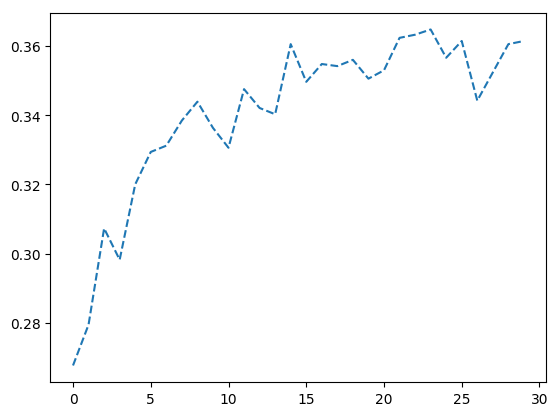

In [0]:
mean_acc_deep_bow = np.mean([deep_cbow_accuracies_1, deep_cbow_accuracies_2, deep_cbow_accuracies_3], axis = 0)
# plt.plot(deep_cbow_accuracies_1)
# plt.plot(deep_cbow_accuracies_2)
# plt.plot(deep_cbow_accuracies_3)
plt.plot(mean_acc_deep_bow, '--')

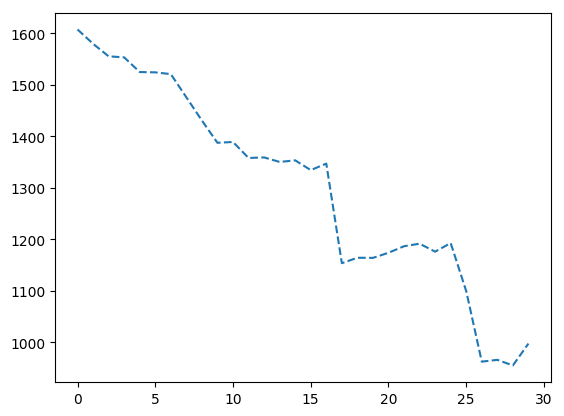

In [0]:
mean_loss_deep_bow = np.mean([deep_cbow_losses_1, deep_cbow_losses_2, deep_cbow_losses_3], axis = 0)
# plt.plot(deep_cbow_losses_1)
# plt.plot(deep_cbow_losses_2)
# plt.plot(deep_cbow_losses_3)
plt.plot(mean_loss_deep_bow, '--')

## EVALUATION OF DEEP CBOW ##

In [0]:
mean_accuracy_deep_cbow = np.mean([0.3842, 0.3751, 0.3688])
std_accuracy_deep_cbow = np.std([0.3842, 0.3751, 0.3688])
print('Mean accuracy of Deep CBOW:', mean_accuracy_deep_cbow,'STD of Deep CBOW:', std_accuracy_deep_cbow)

Mean accuracy of Deep CBOW: 0.3760333333333333 STD of Deep CBOW: 0.006321568019267219


## SUBTREE ##

In [0]:
USE_SUBTREE_DATA = True
deep_cbow_losses_subtree, deep_cbow_accuracies_subtree = train_model(deep_cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
SE_SUBTREE_DATA = False

Shuffling training data
Iter 1000: loss=992.1271, time=6.76s
iter 1000: dev acc=0.3451
new highscore
Iter 2000: loss=888.7780, time=14.47s
iter 2000: dev acc=0.3379
Iter 3000: loss=863.7150, time=22.00s
iter 3000: dev acc=0.3460
new highscore
Iter 4000: loss=818.7865, time=29.65s
iter 4000: dev acc=0.3415
Iter 5000: loss=846.8164, time=37.15s
iter 5000: dev acc=0.3415
Iter 6000: loss=752.5971, time=44.69s
iter 6000: dev acc=0.3333
Iter 7000: loss=808.4378, time=52.20s
iter 7000: dev acc=0.3379
Iter 8000: loss=794.5265, time=59.73s
iter 8000: dev acc=0.3488
new highscore
Iter 9000: loss=694.1032, time=67.36s
iter 9000: dev acc=0.3533
new highscore
Iter 10000: loss=720.0512, time=75.02s
iter 10000: dev acc=0.3551
new highscore
Iter 11000: loss=696.1889, time=82.63s
iter 11000: dev acc=0.3497
Iter 12000: loss=722.6530, time=90.14s
iter 12000: dev acc=0.3415
Iter 13000: loss=657.1049, time=97.65s
iter 13000: dev acc=0.3361
Iter 14000: loss=683.9840, time=105.20s
iter 14000: dev acc=0.3497


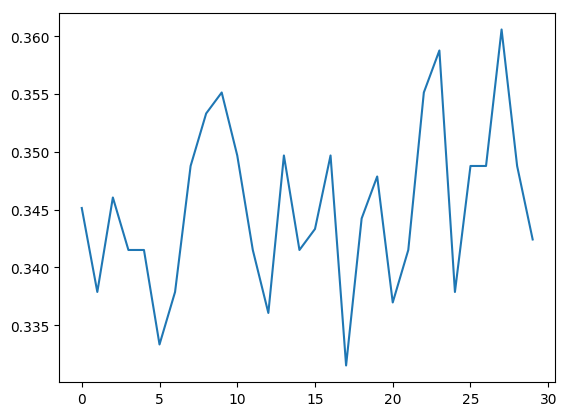

In [0]:
plt.plot(deep_cbow_accuracies_subtree);

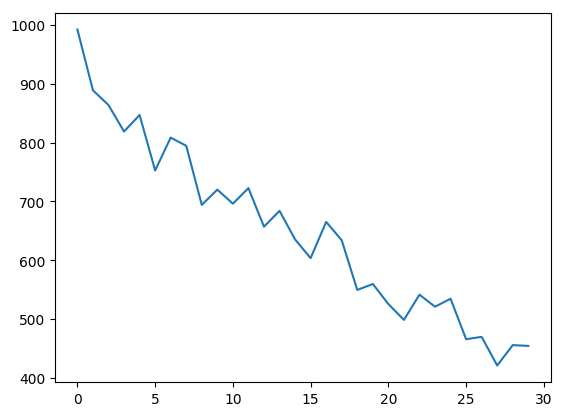

In [0]:
plt.plot(deep_cbow_losses_subtree);

### Analysis of models BOW, CBOW and DEEP CBOW ###

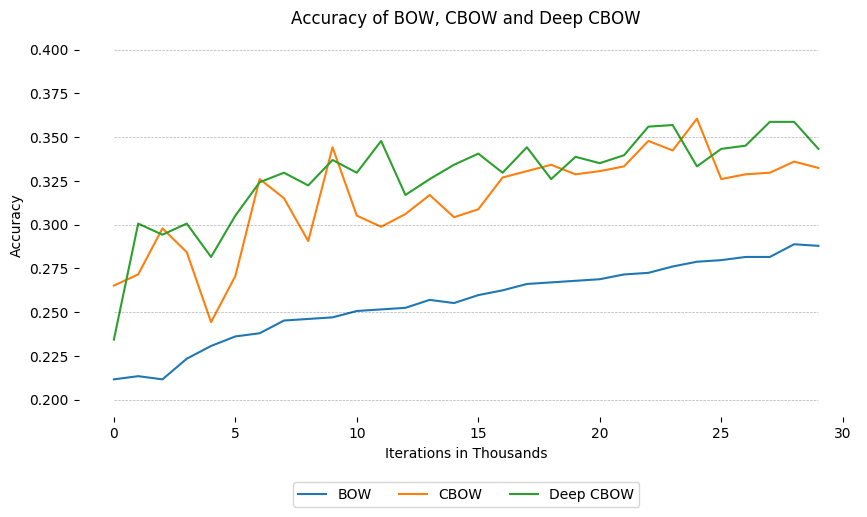

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(bow_accuracies, label='BOW')
ax.plot(cbow_accuracies, label='CBOW')
ax.plot(deep_cbow_accuracies, label='Deep CBOW')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of BOW, CBOW and Deep CBOW')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

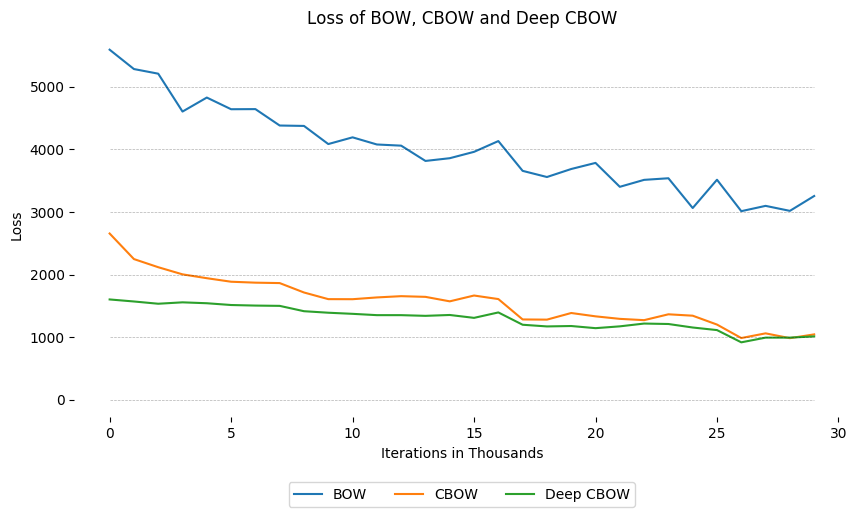

In [0]:
# Losses

fig, ax = plt.subplots(figsize=(10,5))


ax.plot(bow_losses, label='BOW')
ax.plot(cbow_losses, label='CBOW')
ax.plot(deep_cbow_losses, label='Deep CBOW')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Loss')
ax.set_title('Loss of BOW, CBOW and Deep CBOW')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
for y in range(0, 6000, 1000):    
    plt.plot(range(0, 30), [y] * len(range(0, 30)), "--", lw=0.5, color="black", alpha=0.3)    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

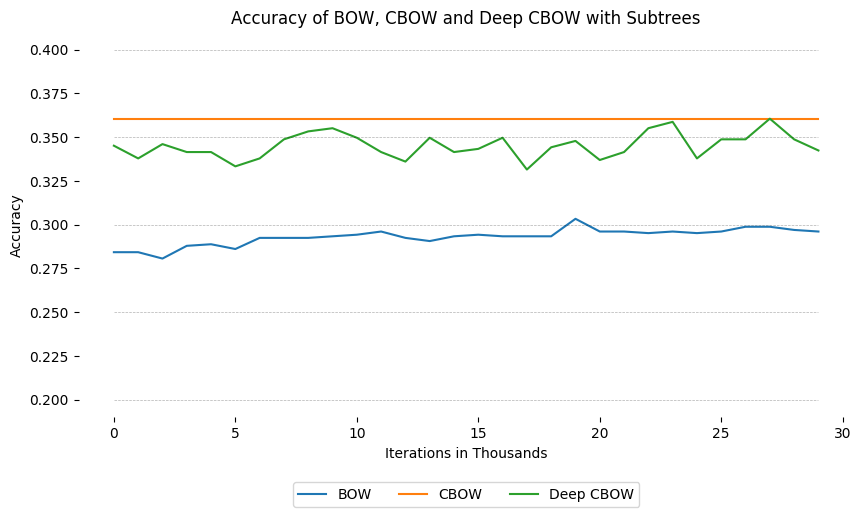

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(bow_accuracies_subtree, label='BOW')
ax.plot(cbow_accuracies_subtree, label='CBOW')
ax.plot(deep_cbow_accuracies_subtree, label='Deep CBOW')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of BOW, CBOW and Deep CBOW with Subtrees')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

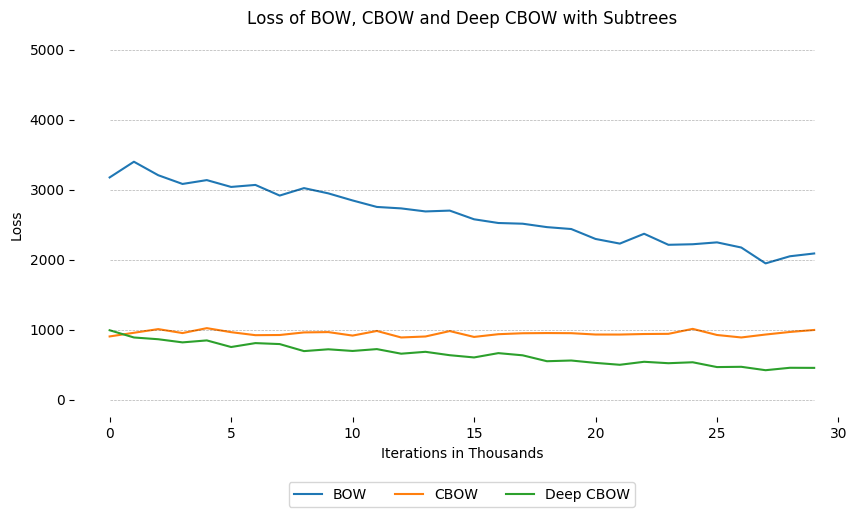

In [0]:
# Losses

fig, ax = plt.subplots(figsize=(10,5))


ax.plot(bow_losses_subtree, label='BOW')
ax.plot(cbow_losses_subtree, label='CBOW')
ax.plot(deep_cbow_losses_subtree, label='Deep CBOW')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Loss')
ax.set_title('Loss of BOW, CBOW and Deep CBOW with Subtrees')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
for y in range(0, 6000, 1000):    
    plt.plot(range(0, 30), [y] * len(range(0, 30)), "--", lw=0.5, color="black", alpha=0.3)    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

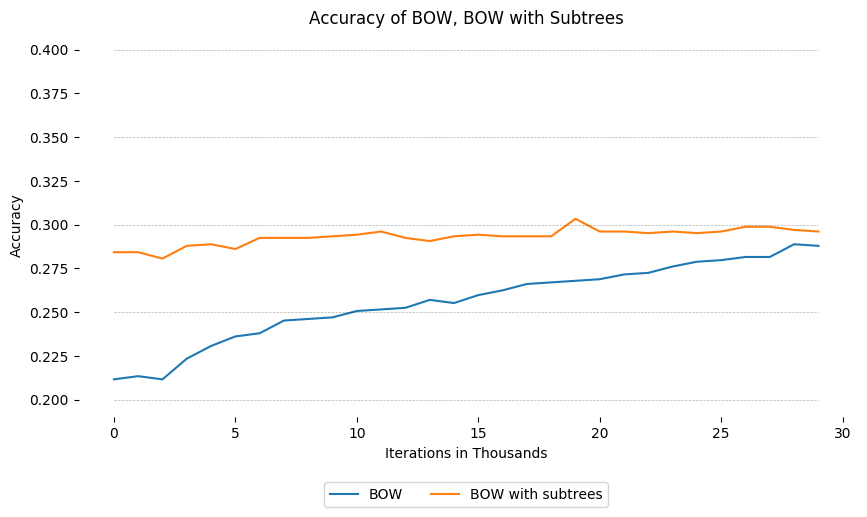

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(bow_accuracies, label='BOW')
ax.plot(bow_accuracies_subtree, label='BOW with subtrees')


ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of BOW, BOW with Subtrees')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);


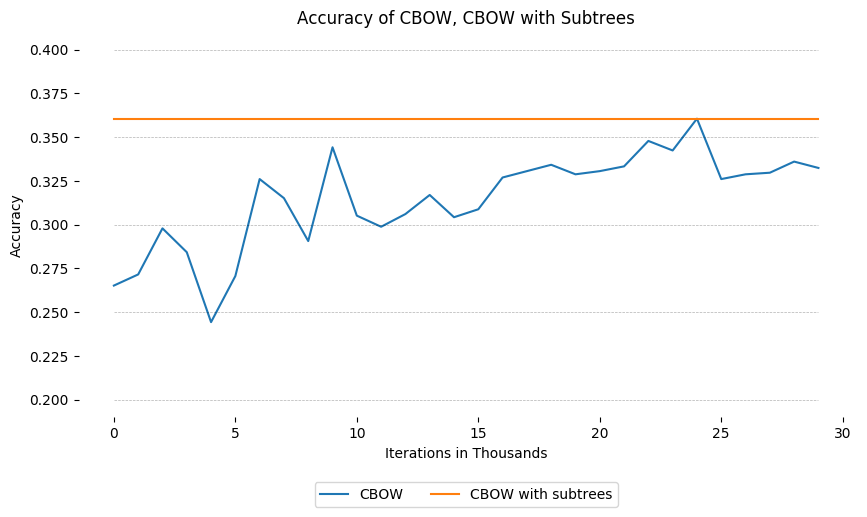

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(cbow_accuracies, label='CBOW')
ax.plot(cbow_accuracies_subtree, label='CBOW with subtrees')


ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of CBOW, CBOW with Subtrees')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);


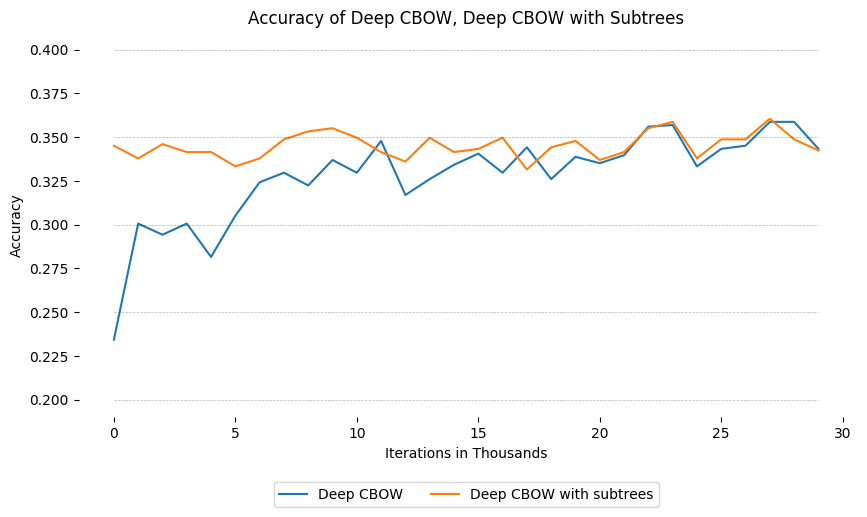

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(deep_cbow_accuracies, label='Deep CBOW')
ax.plot(deep_cbow_accuracies_subtree, label='Deep CBOW with subtrees')


ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Deep CBOW, Deep CBOW with Subtrees')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);


# Pre-trained word embeddings

The Stanford sentiment treebank is a very small data set, since it was manually annotated. This makes it difficult for the model to learn good word embeddings, to learn the "meaning" of the words in our vocabulary.

Think for a moment about the fact that the only error signal that the network receives is from predicting the sentiment!

To mitigate our data sparsity, we can download **pre-trained word embeddings**. 
You can choose which pre-trained word embeddings to use:

- **Glove**. The "original" Stanford Sentiment classification [paper](http://aclweb.org/anthology/P/P15/P15-1150.pdf) used Glove embeddings, which are just another method (like *word2vec*) to get word embeddings from unannotated text. Glove is described in the following paper which you should cite if you use them:
> Jeffrey Pennington, Richard Socher, and Christopher Manning. ["Glove: Global vectors for word representation."](https://nlp.stanford.edu/pubs/glove.pdf) EMNLP 2014. 

- **word2vec**. This is the method that you learned about in class, described in:
> Mikolov, Tomas, et al. ["Distributed representations of words and phrases and their compositionality."](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Advances in neural information processing systems. 2013.

With these pre-trained word embeddings, we can initialize our word embedding lookup table and start form a point where similar words are already close to one another. 

You can choose to keep the word embeddings **fixed** or to train them further.
We will keep them fixed for now.

For the purposes of this lab, it is enough if you understand how word2vec works (whichever vectors you use). If you are interested you may also check out the Glove paper.

You can either download the word2vec vectors, or the Glove vectors.
If you want to compare your results to the Stanford paper later on, then you should use Glove. 
**At the end of this lab you have the option to compare which vectors give you the best performance. For now, simply choose one of them and continue with that.**

In [0]:
# This downloads the Glove 840B 300d embeddings.
# The original file is at http://nlp.stanford.edu/data/glove.840B.300d.zip
# Since that file is 2GB, we provide you with a *filtered version*
# which contains all the words you need for this data set.

# You only need to do this once.
# Please comment this cell out after downloading.

!wget https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt

--2018-12-10 17:48:18--  https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53933315 (51M) [text/plain]
Saving to: ‘glove.840B.300d.sst.txt’

glove.840B.300d.sst 100%[===================>]  51.43M   164MB/s    in 0.3s    

2018-12-10 17:48:19 (164 MB/s) - ‘glove.840B.300d.sst.txt’ saved [53933315/53933315]



In [0]:
# This downloads the word2vec 300D Google News vectors 
# The file has been truncated to only contain words that appear in our data set.
# You can find the original file here: https://code.google.com/archive/p/word2vec/

# You only need to do this once.
# Please comment this out after downloading.
!wget https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt

--2018-12-10 17:48:20--  https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66209703 (63M) [text/plain]
Saving to: ‘googlenews.word2vec.300d.txt’

googlenews.word2vec 100%[===================>]  63.14M   167MB/s    in 0.4s    

2018-12-10 17:48:21 (167 MB/s) - ‘googlenews.word2vec.300d.txt’ saved [66209703/66209703]



In [0]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Copy word vectors *to* Google Drive

# You only need to do this once.
# Please comment this out after running it. 
!cp "glove.840B.300d.sst.txt" "/gdrive/My Drive/"
!cp "googlenews.word2vec.300d.txt" "/gdrive/My Drive/"

cp: cannot stat 'glove.840B.300d.sst.txt': No such file or directory
cp: cannot stat 'googlenews.word2vec.300d.txt': No such file or directory


In [0]:
# If you copied the word vectors to your Drive before,
# here is where you copy them back to the Colab notebook.

# Copy Glove vectors *from* Google Drive
!cp "/gdrive/My Drive/glove.840B.300d.sst.txt" .
!cp "/gdrive/My Drive/googlenews.word2vec.300d.txt" .

At this point you have the pre-trained word embedding files, but what do they look like?

In [0]:
# Exercise: Print the first 4 lines of the files that you downloaded.
# What do you see?

with open("glove.840B.300d.sst.txt") as text:
    for i in range (4):
      line = text.readline()
      print(line)

, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18366 -0.3

#### Exercise: New Vocabulary

Since we now use pre-trained word embeddings, we need to create a new vocabulary. 
This is because of two reasons:

1. Not all words in our training set are in the set of pre-trained word embeddings. We do not want words in our vocabulary that are not in that set.
2. We get to look up the pre-trained word embedding for words in the validation and test set, even if we don't know them from training. 

Now, create a new vocabulary object `v` and load the pre-trained vectors into a `vectors`.

The vocabulary `v` should consist of:
 - a  `<unk>` token at position 0,
 - a  `<pad>` token at position 1, 
 - and then all words in the pre-trained vector set.
 

After storing each vector in a list `vectors`, turn in into a numpy matrix like this:
```python
 vectors = np.stack(vectors, axis=0)
```
 
 


In [0]:
temp_voc = {}

with open("glove.840B.300d.sst.txt") as text:
  for sentence in text:
      word, *values = sentence.split()
      if len(values) == 300:
        temp_voc[word] = np.array(values)
      else:
        print(word)
        
glove_v = Vocabulary()
for word in temp_voc:
  glove_v.count_token(word)
glove_v.build()

vectors = []

for word in glove_v.w2i: 
  if glove_v.w2i[word] <=1:
    if word == "<unk>":
      vectors.append(np.random.uniform(-0.05, 0.5, 300).astype(dtype='float32'))
    elif word == "<pad>":
      vectors.append(np.zeros(300).astype(dtype='float32'))
  else:
    vectors.append(temp_voc[word].astype(dtype='float32'))

vectors = np.stack(vectors, axis=0) 

#### Exercise: words not in our pre-trained set

How many words in the training, dev, and test set are also in your vector set?
How many words are not there?

Store the words that are not in the word vector set in the set below.

In [0]:
words_not_found = set()
# YOUR CODE HERE
for word in v.i2w:
    if word not in glove_v.w2i:
      words_not_found.add(word)
      
print(len(words_not_found))

699


#### Exercise: train Deep CBOW with (fixed) pre-trained embeddings

Now train Deep CBOW again using the pre-trained word vectors.


In [0]:
# We define a dummy class so that we save the model to a different file.
class PTDeepCBOW(DeepCBOW):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(PTDeepCBOW, self).__init__(
        vocab_size, embedding_dim, hidden_dim, output_dim, vocab)

NameError: ignored

In [0]:
# # YOUR CODE HERE
# pt_deep_cbow_model = PTDeepCBOW(len(glove_v.w2i), 300, 100, len(t2i), vocab=glove_v)

# # copy pre-trained word vectors into embeddings table
# pt_deep_cbow_model.embed.weight.data.copy_(torch.from_numpy(vectors))

# # disable training the pre-trained embeddings
# pt_deep_cbow_model.embed.weight.requires_grad = False

# # move model to specified device
# pt_deep_cbow_model = pt_deep_cbow_model.to(device)

# # train the model
# # YOUR CODE HERE
# optimizer = optim.Adam(pt_deep_cbow_model.parameters(), lr=0.0005)
    
# pt_deep_cbow_losses, pt_deep_cbow_accuracies = train_model(
#     pt_deep_cbow_model, optimizer, num_iterations=30000, 
#     print_every=1000, eval_every=1000)

In [0]:
# train function

torch.manual_seed(1231)
pt_deep_cbow_model = PTDeepCBOW(len(glove_v.w2i), 300, 100, len(t2i), vocab=glove_v)
pt_deep_cbow_model.embed.weight.data.copy_(torch.from_numpy(vectors))
pt_deep_cbow_model.embed.weight.requires_grad = False
pt_deep_cbow_model = pt_deep_cbow_model.to(device)
optimizer = optim.Adam(pt_deep_cbow_model.parameters(), lr=0.0005)

pt_deep_cbow_losses_1, pt_deep_cbow_accuracies_1 = train_model(pt_deep_cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(pt_deep_cbow_losses_1, 'pt_deep_cbow_losses_1.txt')
save_data(pt_deep_cbow_accuracies_1, 'pt_deep_cbow_accuracies_1.txt')

torch.manual_seed(1232)
pt_deep_cbow_model = PTDeepCBOW(len(glove_v.w2i), 300, 100, len(t2i), vocab=glove_v)
pt_deep_cbow_model.embed.weight.data.copy_(torch.from_numpy(vectors))
pt_deep_cbow_model.embed.weight.requires_grad = False
pt_deep_cbow_model = pt_deep_cbow_model.to(device)
optimizer = optim.Adam(pt_deep_cbow_model.parameters(), lr=0.0005)

pt_deep_cbow_losses_2, pt_deep_cbow_accuracies_2 = train_model(pt_deep_cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(pt_deep_cbow_losses_2, 'pt_deep_cbow_losses_2.txt')
save_data(pt_deep_cbow_accuracies_2, 'pt_deep_cbow_accuracies_2.txt')

torch.manual_seed(1233)
pt_deep_cbow_model = PTDeepCBOW(len(glove_v.w2i), 300, 100, len(t2i), vocab=glove_v)
pt_deep_cbow_model.embed.weight.data.copy_(torch.from_numpy(vectors))
pt_deep_cbow_model.embed.weight.requires_grad = False
pt_deep_cbow_model = pt_deep_cbow_model.to(device)
optimizer = optim.Adam(pt_deep_cbow_model.parameters(), lr=0.0005)

pt_deep_cbow_losses_3, pt_deep_cbow_accuracies_3 = train_model(pt_deep_cbow_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000)
save_data(pt_deep_cbow_losses_3, 'pt_deep_cbow_losses_3.txt')
save_data(pt_deep_cbow_accuracies_3, 'pt_deep_cbow_accuracies_3.txt')

NameError: ignored

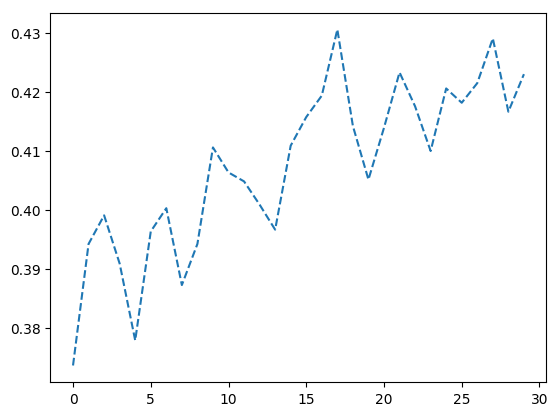

In [0]:
mean_acc_pt_deep_bow = np.mean([pt_deep_cbow_accuracies_1, pt_deep_cbow_accuracies_2, pt_deep_cbow_accuracies_3], axis = 0)
plt.plot(mean_acc_pt_deep_bow, '--')

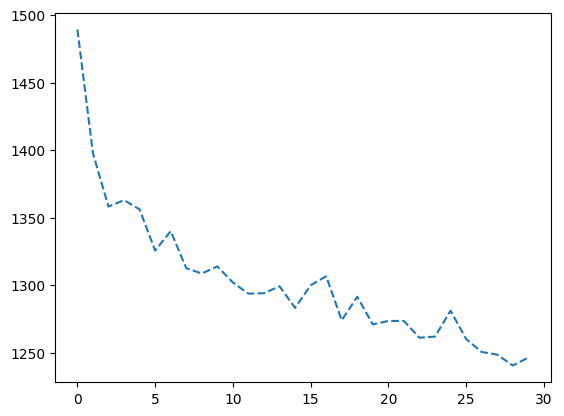

In [0]:
mean_loss_pt_deep_bow = np.mean([pt_deep_cbow_losses_1, pt_deep_cbow_losses_2, pt_deep_cbow_losses_3], axis = 0)
plt.plot(mean_loss_pt_deep_bow, '--')

##EVALUATION OF PT DBOW##

In [0]:
mean_accuracy_pt_deep_cbow = np.mean([0.4332, 0.4523, 0.4296])
std_accuracy_pt_deep_cbow = np.std([0.4332, 0.4523, 0.4296])
print('Mean accuracy of pt deep BOW:', mean_accuracy_pt_deep_cbow,'STD of pt deep BOW:', std_accuracy_pt_deep_cbow)

Mean accuracy of pt deep BOW: 0.4383666666666666 STD of pt deep BOW: 0.009961369829942512


## SUBTREE ##

In [0]:
USE_SUBTREE_DATA = True
pt_deep_cbow_losses_subtree, pt_deep_cbow_accuracies_subtree = train_model(
    pt_deep_cbow_model, optimizer, num_iterations=30000, 
    print_every=1000, eval_every=1000)
USE_SUBTREE_DATA = False

Shuffling training data
Iter 1000: loss=1264.6749, time=4.60s
iter 1000: dev acc=0.4278
new highscore
Iter 2000: loss=1239.2908, time=10.06s
iter 2000: dev acc=0.4251
Iter 3000: loss=1259.7432, time=15.51s
iter 3000: dev acc=0.4323
new highscore
Iter 4000: loss=1294.2382, time=21.08s
iter 4000: dev acc=0.4223
Iter 5000: loss=1266.7727, time=26.57s
iter 5000: dev acc=0.4133
Iter 6000: loss=1244.1591, time=32.04s
iter 6000: dev acc=0.4214
Iter 7000: loss=1292.7694, time=37.51s
iter 7000: dev acc=0.4342
new highscore
Iter 8000: loss=1247.5520, time=43.06s
iter 8000: dev acc=0.4187
Iter 9000: loss=1242.9745, time=48.53s
iter 9000: dev acc=0.4242
Iter 10000: loss=1257.5800, time=54.03s
iter 10000: dev acc=0.4296
Iter 11000: loss=1267.2937, time=59.49s
iter 11000: dev acc=0.4187
Iter 12000: loss=1236.4758, time=64.96s
iter 12000: dev acc=0.4287
Iter 13000: loss=1261.5678, time=70.41s
iter 13000: dev acc=0.4233
Iter 14000: loss=1234.5455, time=75.85s
iter 14000: dev acc=0.4069
Iter 15000: los

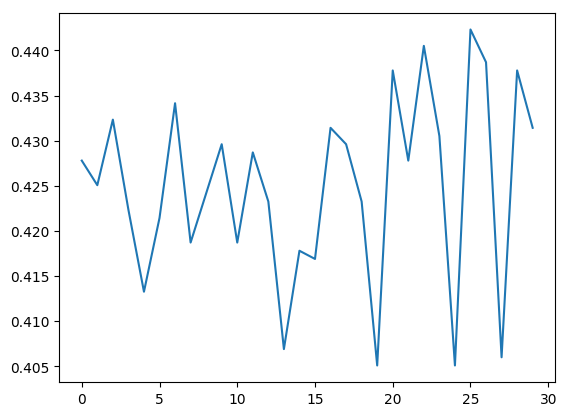

In [0]:
plt.plot(pt_deep_cbow_accuracies_subtree)

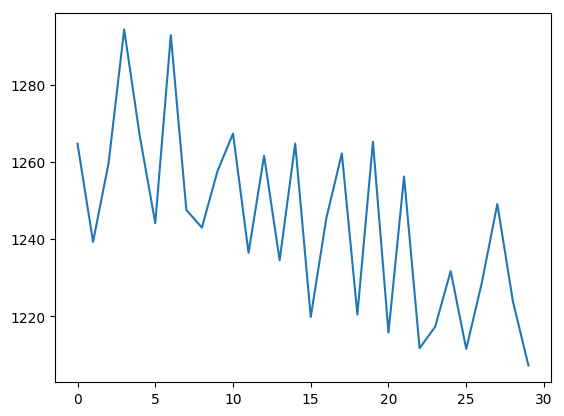

In [0]:
plt.plot(pt_deep_cbow_losses_subtree)

In [0]:
mean_accuracy_pt_deep_cbow_sb = np.mean([0.4277, 0.4271, 0.4296])
std_accuracy_pt_deep_cbow_sb = np.std([0.4277, 0.4271, 0.4296])
print('Mean accuracy of pt deep BOW:', mean_accuracy_pt_deep_cbow_sb,'STD of pt deep BOW:', std_accuracy_pt_deep_cbow_sb)

NameError: ignored

**It looks like we've hit what is possible with just using words.**
Let's move on by incorporating word order!

##Visual of all models so far##

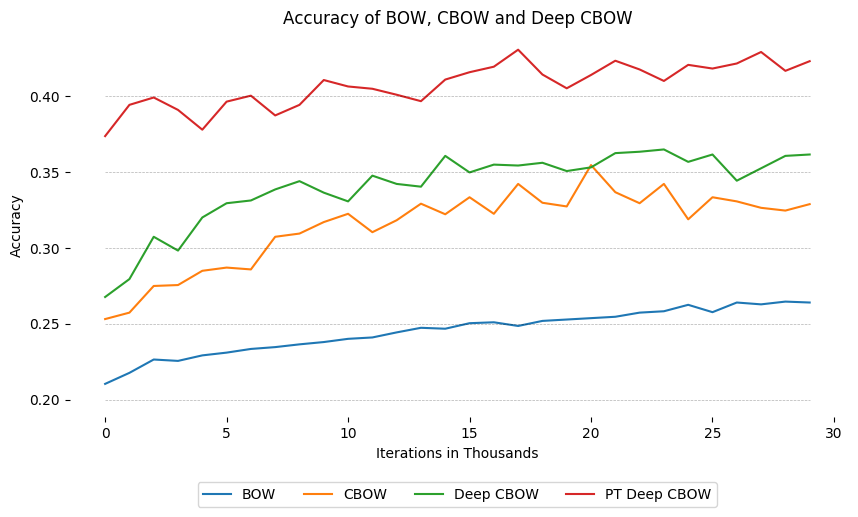

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(mean_acc_bow, label='BOW')
ax.plot(mean_acc_cbow, label='CBOW')
ax.plot(mean_acc_deep_bow, label='Deep CBOW')
ax.plot(mean_acc_pt_deep_bow, label='PT Deep CBOW')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of BOW, CBOW and Deep CBOW')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

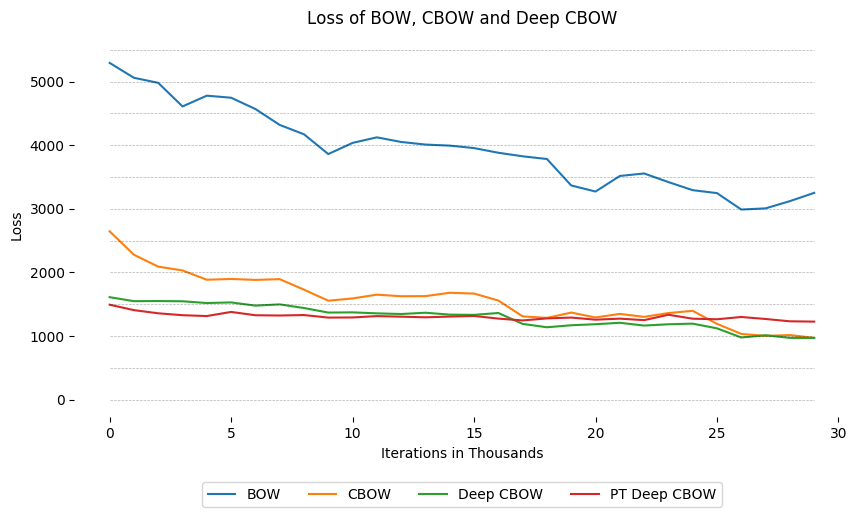

In [0]:
# Losses

fig, ax = plt.subplots(figsize=(10,5))


ax.plot(bow_losses, label='BOW')
ax.plot(cbow_losses, label='CBOW')
ax.plot(deep_cbow_losses, label='Deep CBOW')
ax.plot(pt_deep_cbow_losses, label='PT Deep CBOW')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Loss')
ax.set_title('Loss of BOW, CBOW and Deep CBOW')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
for y in range(0, 6000, 500):    
    plt.plot(range(0, 30), [y] * len(range(0, 30)), "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

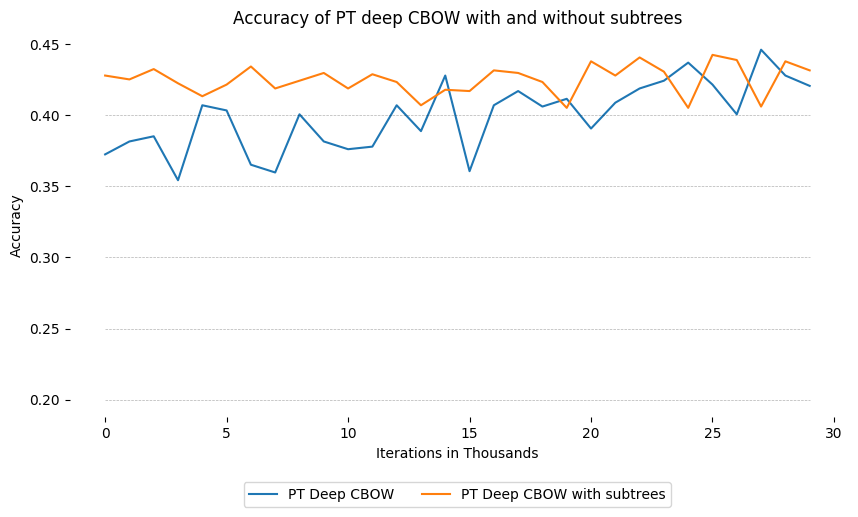

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))


ax.plot(pt_deep_cbow_accuracies, label='PT Deep CBOW')
ax.plot(pt_deep_cbow_accuracies_subtree, label='PT Deep CBOW with subtrees')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of PT deep CBOW with and without subtrees')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

# LSTM

It is time to get more serious. Even with pre-trained word embeddings and multiple layers, we seem to do pretty badly at sentiment classification here. 
The next step we can take is to introduce word order again, and to get a representation of the sentence as a whole, without independence assumptions.

We will get this representation using an **Long Short-Term Memory** (LSTM). As an exercise, we will code our own LSTM cell, so that we get comfortable with its inner workings.
Once we have an LSTM cell, we can call it repeatedly, updating its hidden state one word at a time:

```python
rnn = MyLSTMCell(input_size, hidden_size)

hx = torch.zeros(1, hidden_size)  # initial state
cx = torch.zeros(1, hidden_size)  # initial memory cell
output = []                       # to save intermediate LSTM states

# feed one word at a time
for i in range(n_timesteps):
  hx, cx = rnn(input[i], (hx, cx))
  output.append(hx)
```

If you need some more help understanding LSTMs, then check out these resources:
- Blog post (highly recommended): http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Paper covering LSTM formulas in detail: https://arxiv.org/abs/1503.04069 

#### Exercise: Finish the LSTM cell below. 
You will need to implement the LSTM formulas:

$$
\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
\end{array}
 $$

where $\sigma$ is the sigmoid function.

*Note that the LSTM formulas can differ slightly between different papers. We use the PyTorch LSTM formulation here.*

In [0]:
class MyLSTMCell(nn.Module):
  """Our own LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(MyLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    
    self.output_size = 5
    self.W_i = nn.Linear(input_size, hidden_size*4, bias=True)
    self.W_h = nn.Linear(hidden_size, hidden_size*4, bias=True)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)  

  def forward(self, input_, hx, mask=None):
    """
    input is (batch, input_size)
    hx is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h, prev_c = hx

    x = input_
    
    # project input and prev state
    W_ii, W_if, W_ig, W_io = torch.chunk(self.W_i(x), chunks=4, dim=1)
    W_hi, W_hf, W_hg, W_ho = torch.chunk(self.W_h(prev_h), chunks=4, dim=1)
    i = (W_ii+W_hi).sigmoid()
    f = (W_if+W_hf).sigmoid()
    g = (W_ig+W_hg).tanh()
    o = (W_io+W_ho).sigmoid()
    
    c = (i*prev_c)+(i*g)
    h = o*c.tanh()
    

    return h, c
  
  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

#### Optional: Efficient Matrix Multiplication

It is more efficient to do a few big matrix multiplications than to do many smaller ones.

It is possible to implement the above cell using just **two** linear layers.

This is because the eight linear transformations from one forward pass through an LSTM cell can be done in just two:
$$W_h h + b_h$$
$$W_i x + b_i $$ 

with $h = $ `prev_h` and $x = $ `input_`.

and where: 

$W_h =  \begin{pmatrix}
W_{hi}\\ 
W_{hf}\\ 
W_{hg}\\ 
W_{ho}
\end{pmatrix}$, $b_h = \begin{pmatrix}
b_{hi}\\ 
b_{hf}\\ 
b_{hg}\\ 
b_{ho}
\end{pmatrix}$,  $W_i = \begin{pmatrix}
W_{ii}\\ 
W_{if}\\ 
W_{ig}\\ 
W_{io}
\end{pmatrix}$ and $b_i = \begin{pmatrix}
b_{ii}\\ 
b_{if}\\ 
b_{ig}\\ 
b_{io}
\end{pmatrix}$.

Convince yourself that, after chunking with [torch.chunk](https://pytorch.org/docs/stable/torch.html?highlight=chunk#torch.chunk), the output of those two linear transformations is equivalent to the output of the eight linear transformations in the LSTM cell calculations above.

#### LSTM Classifier

Having an LSTM cell is not enough: we still need some code that calls it repeatedly, and then makes a prediction from the final hidden state. 
You will find that code below. Make sure that you understand it.

In [0]:
class LSTMClassifier(nn.Module):
  """Encodes sentence with an LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(LSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.rnn = MyLSTMCell(embedding_dim, hidden_dim)
    
    self.output_layer = nn.Sequential(     
        nn.Dropout(p=0.5),  # explained later
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):
    
    B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
    T = x.size(1)  # time (the number of words in the sentence)
    
    input_ = self.embed(x)

    # here we create initial hidden states containing zeros
    # we use a trick here so that, if input is on the GPU, then so are hx and cx
    hx = input_.new_zeros(B, self.rnn.hidden_size)
    cx = input_.new_zeros(B, self.rnn.hidden_size)
    
    # process input sentences one word/timestep at a time
    # input is batch-major, so the first word(s) is/are input_[:, 0]
    outputs = []   
    for i in range(T):
      hx, cx = self.rnn(input_[:, i], (hx, cx))
      outputs.append(hx)
    
    # if we have a single example, our final LSTM state is the last hx
    if B == 1:
      final = hx
    else:
      #
      # This part is explained in next section, ignore this else-block for now.
      #
      # we processed sentences with different lengths, so some of the sentences
      # had already finished and we have been adding padding inputs to hx
      # we select the final state based on the length of each sentence
      
      # two lines below not needed if using LSTM form pytorch
      outputs = torch.stack(outputs, dim=0)          # [T, B, D]
      outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]
      
      # to be super-sure we're not accidentally indexing the wrong state
      # we zero out positions that are invalid
      pad_positions = (x == 1).unsqueeze(-1)
      
      outputs = outputs.contiguous()      
      outputs = outputs.masked_fill_(pad_positions, 0.)
        
      mask = (x != 1)  # true for valid positions [B, T]
      lengths = mask.sum(dim=1)                  # [B, 1]

      indexes = (lengths - 1) + torch.arange(B, device=x.device, dtype=x.dtype) * T
      final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]
    
    # we use the last hidden state to classify the sentence
    logits = self.output_layer(final)
    return logits

#### Dropout

Besides not being able to learn meaningful word embeddings, there is another negative effect that can follow from data sparsity and a small data set: *overfitting*. This is a phenomenom that is very likely to occur when fitting strong and expressive models, like LSTMs, to small data. In practice, if your model overfits, this means that it will be very good at predicting (or: 'remembering') the sentiment of the training set, but unable to generalize to new, unseen data in the test set. This is undesirable and one technique to mitigate it is *dropout*. 

A dropout layer is defined by the following formula: $\mathbf{d} \in \{0, 1\}^n$, with $d_j \sim \text{Bernoulli}(p)$, and can be applied to for example a linear layer:

$$\text{tanh}(W(\mathbf{h}\odot \mathbf{d}) + \mathbf{b})$$


These formulas simply mean that we *drop* certain parameters during training (by setting them to zero). Which parameters we drop is stochastically determined by a Bernoulli distribution and the probability of each parameter being dropped is set to $p = 0.5$ in our experiments (see the previous cell of code where we define our output layer). A dropout layer can be applied at many different places in our models. This technique helps against the undesirable effect where our model relies on single parameters for  prediction (e.g. if $h^{\prime}_j$ is large, always predict positive). If we use dropout, the model needs to learn to rely on different parameters, which is desirable when generalizing to unseen data.

**Let's train our LSTM! ** Note that is will be a lot slower, because we need to do many more computations per sentence!

#### Training

In [0]:
# lstm_model = LSTMClassifier(len(glove_v.w2i), 300, 168, len(t2i), glove_v)

# # copy pre-trained word vectors into embeddings table
# with torch.no_grad():
#   lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
#   lstm_model.embed.weight.requires_grad = False

# # print(lstm_model)
# # print_parameters(lstm_model)

# lstm_model = lstm_model.to(device)
# optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)

# # lstm_losses, lstm_accuracies = train_model(lstm_model, optimizer, num_iterations=25000, print_every=250, eval_every=1000)

In [0]:
# train function

torch.manual_seed(1231)
lstm_model = LSTMClassifier(len(glove_v.w2i), 300, 168, len(t2i), glove_v)
with torch.no_grad():
  lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  lstm_model.embed.weight.requires_grad = False
lstm_model = lstm_model.to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)

lstm_losses_1, lstm_accuracies_1 = train_model(lstm_model, optimizer, num_iterations=6000, print_every=200, eval_every=200)
save_data(lstm_losses_1, 'lstm_losses_1.txt')
save_data(lstm_accuracies_1, 'lstm_accuracies_1.txt')

torch.manual_seed(1232)
lstm_model = LSTMClassifier(len(glove_v.w2i), 300, 168, len(t2i), glove_v)
with torch.no_grad():
  lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  lstm_model.embed.weight.requires_grad = False
lstm_model = lstm_model.to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)

lstm_losses_2, lstm_accuracies_2 = train_model(lstm_model, optimizer, num_iterations=6000, print_every=200, eval_every=200)
save_data(lstm_losses_2, 'lstm_losses_2.txt')
save_data(lstm_accuracies_2, 'lstm_accuracies_2.txt')

torch.manual_seed(1233)
lstm_model = LSTMClassifier(len(glove_v.w2i), 300, 168, len(t2i), glove_v)
with torch.no_grad():
  lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  lstm_model.embed.weight.requires_grad = False
lstm_model = lstm_model.to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)

lstm_losses_3, lstm_accuracies_3 = train_model(lstm_model, optimizer, num_iterations=6000, print_every=200, eval_every=200)
save_data(lstm_losses_3, 'lstm_losses_3.txt')
save_data(lstm_accuracies_3, 'lstm_accuracies_3.txt')


Shuffling training data
Iter 200: loss=313.7777, time=9.06s
iter 200: dev acc=0.2543
new highscore
Iter 400: loss=313.0974, time=40.19s
iter 400: dev acc=0.2734
new highscore
Iter 600: loss=317.5890, time=71.77s
iter 600: dev acc=0.2916
new highscore
Iter 800: loss=304.7257, time=103.07s
iter 800: dev acc=0.3315
new highscore
Iter 1000: loss=307.0380, time=133.92s
iter 1000: dev acc=0.3742
new highscore
Iter 1200: loss=291.9819, time=164.66s
iter 1200: dev acc=0.3451
Iter 1400: loss=302.9648, time=195.60s
iter 1400: dev acc=0.3778
new highscore
Iter 1600: loss=288.7870, time=227.12s
iter 1600: dev acc=0.3188
Iter 1800: loss=296.7456, time=258.18s
iter 1800: dev acc=0.3833
new highscore
Iter 2000: loss=294.3216, time=289.21s
iter 2000: dev acc=0.3615
Iter 2200: loss=277.7581, time=320.43s
iter 2200: dev acc=0.3797
Iter 2400: loss=284.8597, time=351.44s
iter 2400: dev acc=0.3769
Iter 2600: loss=272.8080, time=382.50s
iter 2600: dev acc=0.3915
new highscore
Iter 2800: loss=269.9740, time=

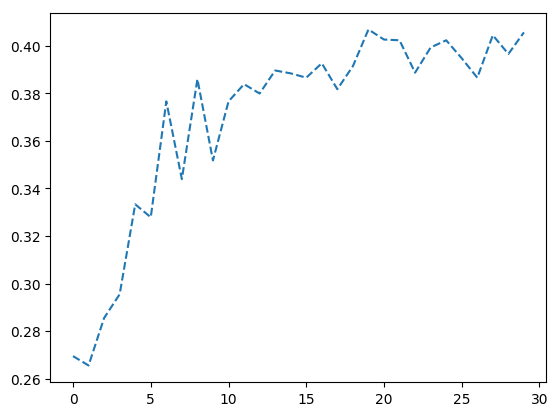

In [0]:
mean_acc_lstm = np.mean([lstm_accuracies_1, lstm_accuracies_2, lstm_accuracies_3], axis = 0)
plt.plot(mean_acc_lstm, '--')

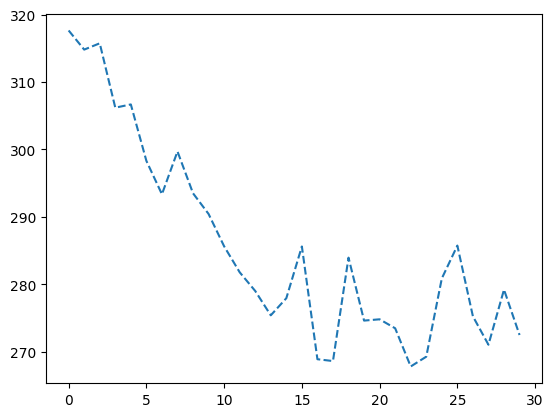

In [0]:
mean_loss_lstm = np.mean([lstm_losses_1, lstm_losses_2, lstm_losses_3], axis = 0)
plt.plot(mean_loss_lstm, '--')

## EVALUATION OF LSTMS ##

In [0]:
mean_accuracy_lstm = np.mean([0.4222, 0.4269, 0.4254])
std_accuracy_lstm = np.std([0.4222, 0.4269, 0.4254])
print('Mean accuracy of LSTMS:', mean_accuracy_lstm,'STD of LSTMS:', std_accuracy_lstm)

Mean accuracy of LSTMS: 0.42483333333333334 STD of LSTMS: 0.001960158723731879


## SUBTREES ##

In [0]:
USE_SUBTREE_DATA = True
lstm_losses_subtree, lstm_accuracies_subtree = train_model(
    lstm_model, optimizer, num_iterations=30000, 
    print_every=1000, eval_every=1000)
USE_SUBTREE_DATA = False

Shuffling training data
Iter 1000: loss=1145.8562, time=56.92s
iter 1000: dev acc=0.4314
new highscore
Iter 2000: loss=1189.3122, time=134.54s
iter 2000: dev acc=0.4187
Iter 3000: loss=1137.3870, time=212.61s
iter 3000: dev acc=0.4251
Iter 4000: loss=1120.5679, time=290.22s
iter 4000: dev acc=0.4133
Iter 5000: loss=1122.0551, time=367.79s
iter 5000: dev acc=0.4423
new highscore
Iter 6000: loss=1151.5287, time=444.59s
iter 6000: dev acc=0.4460
new highscore
Iter 7000: loss=1139.6842, time=523.18s
iter 7000: dev acc=0.4360
Iter 8000: loss=1114.9963, time=600.83s
iter 8000: dev acc=0.4305
Iter 9000: loss=1095.4262, time=678.58s
iter 9000: dev acc=0.4323
Iter 10000: loss=1109.9298, time=755.34s
iter 10000: dev acc=0.4369
Iter 11000: loss=1065.3167, time=833.27s
iter 11000: dev acc=0.4378
Iter 12000: loss=1035.6848, time=910.82s
iter 12000: dev acc=0.4432
Iter 13000: loss=1100.3052, time=988.73s
iter 13000: dev acc=0.4342
Iter 14000: loss=1081.3808, time=1067.48s
iter 14000: dev acc=0.4441


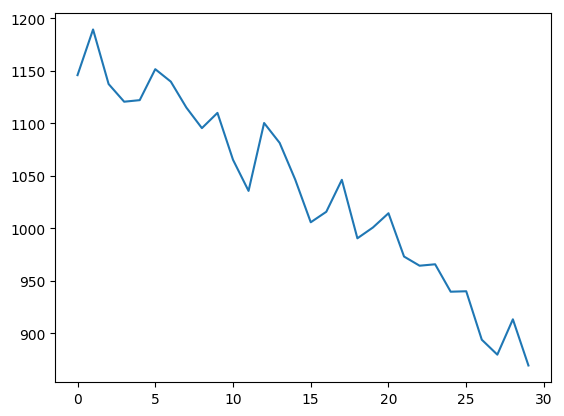

In [0]:
plt.plot(lstm_losses_subtree)

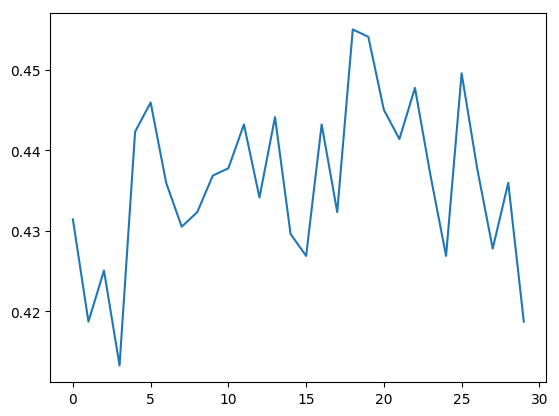

In [0]:
plt.plot(lstm_accuracies_subtree)

### Visual of models so far ### 

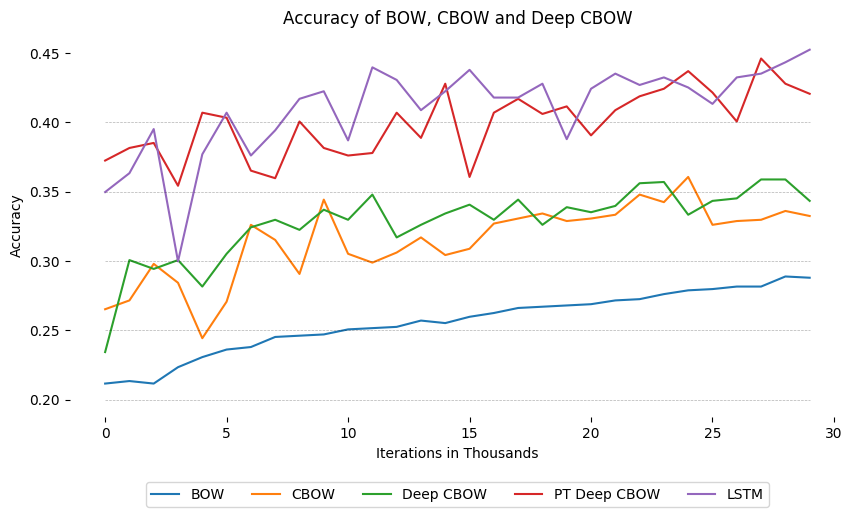

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(bow_accuracies, label='BOW')
ax.plot(cbow_accuracies, label='CBOW')
ax.plot(deep_cbow_accuracies, label='Deep CBOW')
ax.plot(pt_deep_cbow_accuracies, label='PT Deep CBOW')
ax.plot(lstm_accuracies, label='LSTM')


ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of BOW, CBOW and Deep CBOW')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

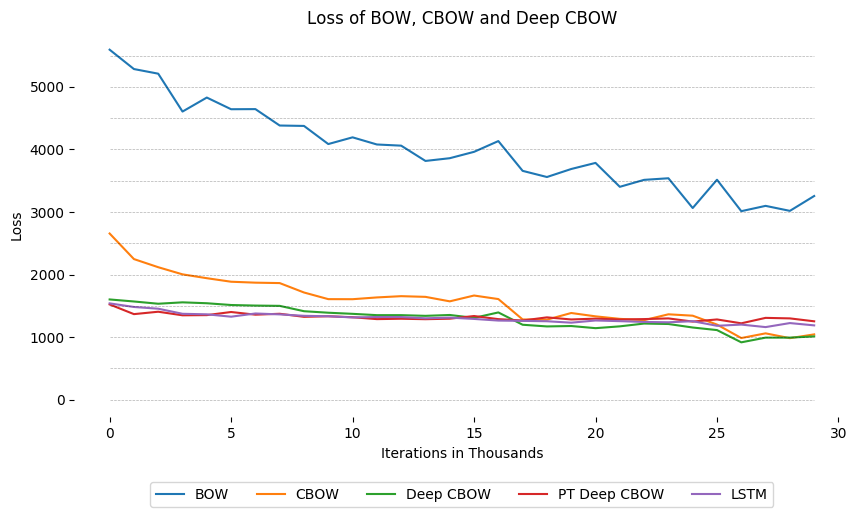

In [0]:
# Losses

fig, ax = plt.subplots(figsize=(10,5))


ax.plot(bow_losses, label='BOW')
ax.plot(cbow_losses, label='CBOW')
ax.plot(deep_cbow_losses, label='Deep CBOW')
ax.plot(pt_deep_cbow_losses, label='PT Deep CBOW')
ax.plot(lstm_losses, label='LSTM')


ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Loss')
ax.set_title('Loss of BOW, CBOW and Deep CBOW')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
for y in range(0, 6000, 500):    
    plt.plot(range(0, 30), [y] * len(range(0, 30)), "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

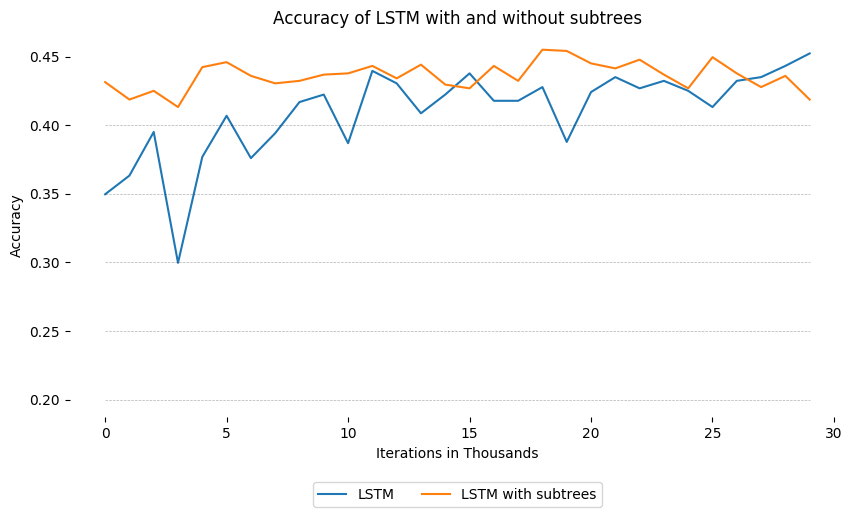

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))


ax.plot(lstm_accuracies, label='LSTM')
ax.plot(lstm_accuracies_subtree, label='LSTM with subtrees')


ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of LSTM with and without subtrees')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5);

# Mini-batching



**Why is the LSTM so slow?** Despite our best efforts, we still need to make a lot of matrix multiplications per example (linear in the length of the example) just to get a single classification, and we can only process the 2nd word once we have computed the hidden state for the 1st word (sequential computation).

GPUs are more efficient if we do a few big matrix multiplications, rather than lots of small ones. If we could process multiple examples at the same time, then we could exploit that. We still process the input sequentially, but now we can do so for multiple sentences at the same time.

Up to now our "minibatch" consisted of a single example. This was for a reason: the sentences in our data sets have **different lengths**, and this makes it difficult to process them at the same time.

Consider a batch of 2 sentences:

```
this movie is bad
this movie is super cool !
```

Let's say the IDs for these sentences are:

```
2 3 4 5
2 3 4 6 7 8
```

We cannot feed PyTorch an object with variable length rows! We need to turn this into a matrix.

The solution is to add **padding values** to our mini-batch:

```
2 3 4 5 1 1
2 3 4 6 7 8
```

Whenever a sentence is shorter than the longest sentence in a mini-batch, we just use a padding value (here: 1) to fill the matrix.

In our computation, we should **ignore** the padding positions (e.g. mask them out). Paddings should not contribute to the loss.

#### Mini-batch feed
We will now code a `get_minibatch` function that will replace our `get_example` function, and returns a mini-batch of the requested size.

In [0]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""
  
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  
  batch = []
  
  # yield minibatches
  for example in data:
    batch.append(example)
    
    if len(batch) == batch_size:
      yield batch
      batch = []
      
  # in case there is something left
  if len(batch) > 0:
    yield batch

#### Pad function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequencen in the minibatch.

In [0]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New prepare function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [0]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])
  
  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]
  
  x = torch.LongTensor(x)
  x = x.to(device)
  
  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)
  
  return x, y

In [0]:
# Let's test our new function.
# This should give us 3 examples.
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))
for ex in mb:
  print(ex)

Example(tokens=['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], tree=Tree('3', [Tree('2', [Tree('2', ['The']), Tree('2', ['Rock'])]), Tree('4', [Tree('3', [Tree('2', ['is']), Tree('4', [Tree('2', ['destined']), Tree('2', [Tree('2', [Tree('2', [Tree('2', [Tree('2', ['to']), Tree('2', [Tree('2', ['be']), Tree('2', [Tree('2', ['the']), Tree('2', [Tree('2', ['21st']), Tree('2', [Tree('2', [Tree('2', ['Century']), Tree('2', ["'s"])]), Tree('2', [Tree('3', ['new']), Tree('2', [Tree('2', ['``']), Tree('2', ['Conan'])])])])])])])]), Tree('2', ["''"])]), Tree('2', ['and'])]), Tree('3', [Tree('2', ['that']), Tree('3', [Tree('2', ['he']), Tree('3', [Tree('2', ["'s"]), Tree('3', [Tree('2', ['going']), Tree('3', [Tree('2', ['to']), Tree('4', [Tree('3', [Tree('

In [0]:
# We should find 1s at the end where padding is.
x, y = prepare_minibatch(mb, v)
print("x", x)
print("y", y)

x tensor([[  14, 1098,   10, 3554,    8,   27,    4, 2912, 3555,    9,  151,   60,
         5869,   61,    5,   11,   82,    9,  290,    8,   84,    6, 5870,   75,
         3556,   38, 1887, 2913,    3, 8737, 2139, 5871,   48,  828, 8738,    2,
            1,    1,    1],
        [  14, 2914, 2140, 5872,    7,   60,   14, 4473,    7,    4, 5873,   61,
         5874,   10,   49,  878,   11,    6, 5875,    7,  679,   65,   31, 3557,
         2141, 8739, 1099,  829,    9, 8740,  629,    7, 8741, 5876,    9, 8742,
            2,    1,    1],
        [8743, 5877, 2142, 8744,    6, 8745,    7, 1684,   33,    6,  171,  752,
         1269,    3,    6,  171,   37,  316, 8746,    8,    4,   52,   33,   17,
            4,  306, 3558,  377,  680,    4, 1021,    3, 4474,    3,  512,    7,
            4,  277,    2]], device='cuda:0')
y tensor([3, 4, 3], device='cuda:0')


#### Evaluate (mini-batch version)

We can now update our evaluation function to use minibatches

In [0]:
def evaluate(model, data, 
             batch_fn=get_minibatch, prep_fn=prepare_minibatch,
             batch_size=16):
  """Accuracy of a model on given data set (using minibatches)"""
  correct = 0
  total = 0
  model.eval()  # disable dropout

  for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
    x, targets = prep_fn(mb, model.vocab)
    with torch.no_grad():
      logits = model(x)
      
    predictions = logits.argmax(dim=-1).view(-1)
    
    # add the number of correct predictions to the total correct
    correct += (predictions == targets.view(-1)).sum().item()
    total += targets.size(0)

  return correct, total, correct / float(total)

## LSTM (Mini-batched) ##

With this, let's run the LSTM again but now using minibatches!

In [0]:
# lstm_model = LSTMClassifier(len(glove_v.w2i), 300, 168, len(t2i), glove_v)
# with torch.no_grad():
#   lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
#   lstm_model.embed.weight.requires_grad = False

# lstm_model = lstm_model.to(device)
# batch_size = 25
# optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)
# mb_lstm_losses, mb_lstm_accuracies = train_model(lstm_model, optimizer, num_iterations=30000, print_every=1000, eval_every=1000,batch_size=batch_size,batch_fn=get_minibatch, prep_fn=prepare_minibatch,eval_fn=evaluate)

In [0]:
# train function

torch.manual_seed(1231)
lstm_model = LSTMClassifier(len(glove_v.w2i), 300, 168, len(t2i), glove_v)
with torch.no_grad():
  lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  lstm_model.embed.weight.requires_grad = False

lstm_model = lstm_model.to(device)
batch_size = 25
optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)
mb_lstm_losses_1, mb_lstm_accuracies_1 = train_model(lstm_model, optimizer, num_iterations=6000, print_every=200, eval_every=200,batch_size=batch_size,batch_fn=get_minibatch, prep_fn=prepare_minibatch,eval_fn=evaluate)
save_data(mb_lstm_losses_1, 'mb_lstm_losses_1.txt')
save_data(mb_lstm_accuracies_1, 'mb_lstm_accuracies_1.txt')

torch.manual_seed(1232)
lstm_model = LSTMClassifier(len(glove_v.w2i), 300, 168, len(t2i), glove_v)
with torch.no_grad():
  lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  lstm_model.embed.weight.requires_grad = False

lstm_model = lstm_model.to(device)
batch_size = 25
optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)
mb_lstm_losses_2, mb_lstm_accuracies_2 = train_model(lstm_model, optimizer, num_iterations=6000, print_every=200, eval_every=200,batch_size=batch_size,batch_fn=get_minibatch, prep_fn=prepare_minibatch,eval_fn=evaluate)
save_data(mb_lstm_losses_2, 'mb_lstm_losses_2.txt')
save_data(mb_lstm_accuracies_2, 'mb_lstm_accuracies_2.txt')


torch.manual_seed(1233)
lstm_model = LSTMClassifier(len(glove_v.w2i), 300, 168, len(t2i), glove_v)
with torch.no_grad():
  lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  lstm_model.embed.weight.requires_grad = False

lstm_model = lstm_model.to(device)
batch_size = 25
optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)
mb_lstm_losses_3, mb_lstm_accuracies_3 = train_model(lstm_model, optimizer, num_iterations=6000, print_every=200, eval_every=200,batch_size=batch_size,batch_fn=get_minibatch, prep_fn=prepare_minibatch,eval_fn=evaluate)
save_data(mb_lstm_losses_3, 'mb_lstm_losses_3.txt')
save_data(mb_lstm_accuracies_3, 'mb_lstm_accuracies_3.txt')

Shuffling training data
Iter 200: loss=311.8187, time=20.16s
iter 200: dev acc=0.3506
new highscore
Shuffling training data
Iter 400: loss=283.5762, time=42.07s
iter 400: dev acc=0.4105
new highscore
Iter 600: loss=264.1667, time=63.68s
iter 600: dev acc=0.3987
Shuffling training data
Iter 800: loss=258.4335, time=85.23s
iter 800: dev acc=0.4124
new highscore
Iter 1000: loss=255.6463, time=107.18s
iter 1000: dev acc=0.4360
new highscore
Shuffling training data
Iter 1200: loss=253.5299, time=129.12s
iter 1200: dev acc=0.4169
Shuffling training data
Iter 1400: loss=249.7748, time=150.81s
iter 1400: dev acc=0.4223
Iter 1600: loss=244.7771, time=172.66s
iter 1600: dev acc=0.4332
Shuffling training data
Iter 1800: loss=242.9747, time=194.41s
iter 1800: dev acc=0.4287
Iter 2000: loss=237.4741, time=215.98s
iter 2000: dev acc=0.4278
Shuffling training data
Iter 2200: loss=237.9904, time=237.64s
iter 2200: dev acc=0.4332
Shuffling training data
Iter 2400: loss=238.4307, time=259.36s
iter 2400:

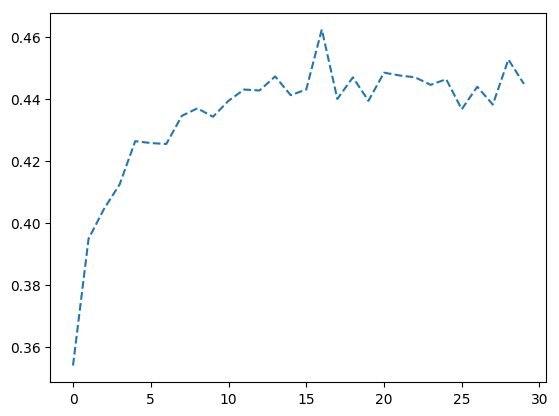

In [0]:
mean_acc_mb_lstm = np.mean([mb_lstm_accuracies_1, mb_lstm_accuracies_2, mb_lstm_accuracies_3], axis = 0)
plt.plot(mean_acc_mb_lstm, '--')

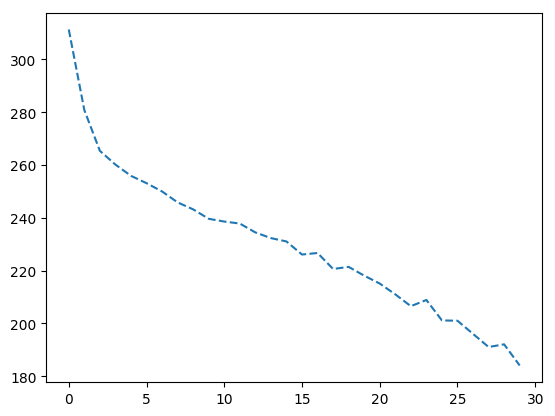

In [0]:
mean_loss_mb_lstm = np.mean([mb_lstm_losses_1, mb_lstm_losses_2, mb_lstm_losses_3], axis = 0)
plt.plot(mean_loss_mb_lstm, '--')

## EVALUATION OF MINI-BATCHED ##

In [0]:
mean_accuracy_mb_lstm = np.mean([0.4578, 0.4587, 0.4705])
std_accuracy_mb_lstm = np.std([0.4578, 0.4587, 0.4705])
print('Mean accuracy of LSTMS:', mean_accuracy_mb_lstm,'STD of LSTMS:', std_accuracy_mb_lstm)

Mean accuracy of LSTMS: 0.4623333333333333 STD of LSTMS: 0.00578638248150104


## SUBTREE HERE IS MISSIIINGG!! ##

# VISUAL so far#

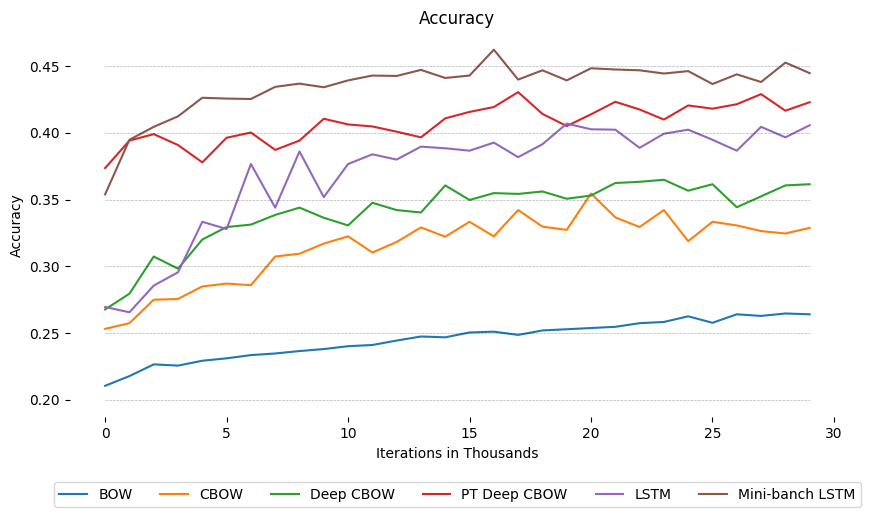

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(mean_acc_bow, label='BOW')
ax.plot(mean_acc_cbow, label='CBOW')
ax.plot(mean_acc_deep_bow, label='Deep CBOW')
ax.plot(mean_acc_pt_deep_bow, label='PT Deep CBOW')
ax.plot(mean_acc_lstm, label='LSTM')
ax.plot(mean_acc_mb_lstm, label='Mini-banch LSTM')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40, 0.45)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6);

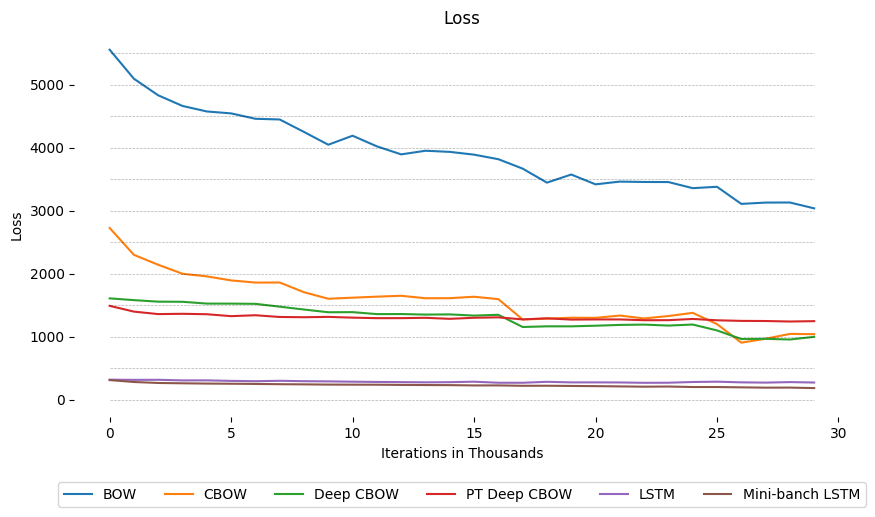

In [0]:
# Losses

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(mean_loss_bow, label='BOW')
ax.plot(mean_loss_cbow, label='CBOW')
ax.plot(mean_loss_deep_bow, label='Deep CBOW')
ax.plot(mean_loss_pt_deep_bow, label='PT Deep CBOW')
ax.plot(mean_loss_lstm, label='LSTM')
ax.plot(mean_loss_mb_lstm, label='Mini-banch LSTM')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Loss')
ax.set_title('Loss')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
for y in range(0, 6000, 500):    
    plt.plot(range(0, 30), [y] * len(range(0, 30)), "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6);

# Tree LSTM

In the final part of this lab we will exploit the tree-structure of our data. 
Until now we only used the surface tokens, but remember that our data examples include trees with a sentiment score at every node.

In particular, we will implement **N-ary Tree-LSTMs** which are described in:

> Kai Sheng Tai, Richard Socher, and Christopher D. Manning. [Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks](http://aclweb.org/anthology/P/P15/P15-1150.pdf) ACL 2015.

Since our trees are binary, N=2, and we can refer to these as *Binary Tree-LSTMs*.

You should read this paper carefully and make sure that you understand the approach. You will also find our LSTM baseline there.
Note however that Tree LSTMs were also invented around the same time by two other groups:

> Phong Le and Willem Zuidema. [Compositional distributional semantics with long short term memory](http://anthology.aclweb.org/S/S15/S15-1002.pdf). *SEM 2015.

> Xiaodan Zhu, Parinaz Sobihani,  and Hongyu Guo. [Long short-term memory over recursive structures](http://proceedings.mlr.press/v37/zhub15.pdf). ICML 2015.

It is good scientific practice to cite all three papers in your report.

If you study equations (9) to (14) in the paper, you will find that they are not all too different from the original LSTM that you already have.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** made by this function. Let's look at it again:



In [0]:
ex = next(examplereader("trees/dev.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

Note that the tree is **binary**. Every node has two children, except for pre-terminal nodes.

A tree like this can be described by a sequence of **SHIFT (0)** and **REDUCE (1)** actions.

We can use the transitions like this to construct the tree:
- **reverse** the sentence (a list of tokens) and call this the **buffer**
   - the first word is now on top (last in the list), and we would get it when calling pop() on the buffer
- create an empty list and call it the **stack**
- iterate through the transition sequence:
  - if it says SHIFT(0), we pop a word from the buffer, and push it to the stack
  - if it says REDUCE(1), we pop the **top two items** from the stack, and combine them (e.g. with a tree LSTM!), creating a new node that we push back on the stack
  
Convince yourself that going through the transition sequence above will result in the tree that you see.
For example, we would start by putting the following words on the stack (by shifting 5 times, starting with `It`):

```
Top of the stack:
-----------------
film
lovely
a 
's  
It
```
Now we find a REDUCE in the transition sequence, so we get the top two words (film and lovely), and combine them, so our new stack becomes:
```
Top of the stack:
-----------------
lovely film
a 
's  
It
```

We will use this approach when encoding sentences with our Tree LSTM.
Now, our sentence is a (reversed) list of word embeddings.
When we shift, we move a word embedding to the stack.
When we reduce, we apply a Tree LSTM to the top two vectors, and the result is a single vector that we put back on the stack.
After going through the whole transition sequence, we will have the root node on our stack! We can use that to classify the sentence.



## Obtaining the transition sequence



So what goes on in the `transitions_from_treestring` function?

The idea ([explained in this blog post](https://devblogs.nvidia.com/recursive-neural-networks-pytorch/)) is that, if we had a tree, we could traverse through the tree, and every time that we find a node containing only a word, we output a SHIFT.
Every time **after** we have finished visiting the children of a node, we output a REDUCE.
(What is this tree traversal called?)

However, our `transitions_from_treestring` function operates directly on the string representation. It works as follows.

We start with the representation:

```
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
```

First we remove pre-terminal nodes (and add spaces before closing brackets):

```
(3 It (4 (4 's (4 (3 a (4 lovely film ) ) (3 with (4 (3 lovely performances ) (2 by (2 (2 Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove node labels:

```
( It ( ( 's ( ( a ( lovely film ) ) ( with ( ( lovely performances) ( by ( ( Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove opening brackets:

```
It 's a lovely film ) ) with lovely performances ) by Buy and ) Accorsi ) ) ) ) ) ) . ) )
```

Now we replace words by S (for SHIFT), and closing brackets by R (for REDUCE):

```
S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 
```

Et voila. We just obtained the transition sequence!

In [0]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1


## Coding the Tree LSTM

The code below contains a Binary Tree LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise 
Check the `forward` function and complete the Tree LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [0]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)  

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))    
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)
    
    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation
    
    # YOUR CODE HERE
    # The shape of each of these is [batch_size, hidden_size]

    i = i.sigmoid()
    f_l = f_l.sigmoid()
    f_r = f_r.sigmoid()
    g = g.tanh()
    o = o.sigmoid()

    c = i*g + (f_l*prev_c_l + f_r*prev_c_r)
    h = o*c.tanh()
    
    return h, c
  
  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

## Explanation of the TreeLSTM class


The code below contains the TreeLSTM class, which implements everything we need in order to encode a sentence from word embeddings. The calculations are the same as in the paper, implemented such that the class `TreeLSTMCell` above is as general as possible and only takes two children to reduce them into a parent. 


**Initialize $\mathbf{h}$ and $\mathbf{c}$ outside of the cell for the leaves**

At the leaves of each tree the children nodes are **empty**, whereas in higher levels the nodes are binary tree nodes that *do* have a left and right child (but no input $x$). By initializing the leaf nodes outside of the cell class (`TreeLSTMCell`), we avoid if-else statements in the forward pass.

The `TreeLSTM` class (among other things) pre-calculates an initial $h$ and $c$ for every word in the sentence. Since the initial left and right child are 0, the only calculations we need to do are based on $x$, and we can drop the forget gate calculation (`prev_c_l` and `prev_c_r` are zero). The calculations we do in order to initalize $h$ and $c$ are then:

$$
c_1 =  W^{(u)}x_1 \\
o_1 = \sigma (W^{(i)}x_1) \\
h_1 = o_1 \odot \text{tanh}(c_1)$$
*NB: note that these equations are chosen as initializations of $c$ and $h$, other initializations are possible and might work equally well.*

**Sentence Representations**

All our leaf nodes are now initialized, so we can start processing the sentence in its tree form. Each sentence is represented by a buffer (initially a list with a concatenation of $[h_1, c_1]$ for every word in the reversed sentence), a stack (initially an empty list) and a transition sequence. To encode our sentence, we construct the tree from its transition sequence as explained earlier. 

*A short example that constructs a tree:*

We loop over the time dimension of the batched transition sequences (i.e. row by row), which contain values of 0's, 1's and 2's (representing SHIFT, REDUCE and padding respectively). If we have a batch of size 2 where the first example has a transition sequence given by [0, 0, 1, 0, 0, 0, 1] and the second by [0, 0, 1, 0, 0, 1], our transition batch will be given by the following two-dimensional numpy array:

$$
\text{transitions} = 
\begin{pmatrix}
0 & 0\\ 
0 & 0\\ 
1 & 1\\ 
0 & 0\\ 
0 & 0\\ 
0 & 1\\ 
1 & 2
\end{pmatrix}
$$
The inner loop (`for transition, buffer, stack in zip(t_batch, buffers, stacks)`) goes over each example in the batch and updates its buffer and stack. The nested loop for this example will then do roughy the following:

```
Time = 0:  t_batch = [0, 0], the inner loop performs 2 SHIFTs. 

Time = 1:  t_batch = [0, 0], ".."

Time = 2:  t_batch = [1, 1], causing the inner loop to fill the list child_l and child_r for both examples in the batch. Now the statement if child_l will return True, triggering a REDUCE action to be performed by our Tree LSTM cell with a batch size of 2. 

Time = 3:  t_batch = [0, 0], "..".

Time = 4:  t_batch = [0, 0], ".."

Time = 5:  t_batch = [0, 1], one SHIFT will be done and another REDUCE action will be performed by our Tree LSTM, this time of batch size 1.  

Time = 6:  t_batch = [1, 2], triggering another REDUCE action with batch size 1.
```
*NB: note that this was an artificial example for the purpose of demonstrating parts of the code, the transition sequences do not necessarily represent actual trees.*

**Batching and Unbatching**

Within the body of the outer loop over time, we use the functions for batching and unbatching. 

*Batching*

Before passing two lists of children to the reduce layer (an instance of `TreeLSTMCell`), we batch the children as they are at this point a list of tensors of variable length based on how many REDUCE actions there are to perform at a certain time step across the batch (let's call the length `L`). To do an efficient forward pass we want to transform the list to a pair of tensors of shape `([L, D], [L, D])`, which the function `batch` achieves. 

*Unbatching*

In the same line where we batched the children, we unbatch the output of the forward pass to become a list of states of length `L` again. We do this because we need to loop over each example's transition at the current time step and push the children that are reduced into a parent to the stack.

*The batch and unbatch functions let us switch between the "PyTorch world" (Tensors) and the Python world (easy to manipulate lists).*


In [0]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but 
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
  """
  Turns a list of states into a single tensor for fast processing. 
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

Take some time to understand the class below, having read the explanation above.

In [0]:
class TreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = TreeLSTMCell(input_size, hidden_size)

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)
    
    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h
    
    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        for transition, stack in zip(t_batch, stacks):
          if transition == REDUCE:
            stack.append(next(reduced))

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return final

Just like the LSTM before, we will need an extra class that does the classifications.

In [0]:
class TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = TreeLSTM(embedding_dim, hidden_dim)
    self.output_layer = nn.Sequential(     
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):
    
    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)
    
    # we use the root/top state of the Tree LSTM to classify the sentence
    root_states = self.treelstm(emb, transitions)

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(root_states)
    return logits

## Special prepare function for Tree LSTM

We need yet another prepare function. For our implementation our sentences to be *reversed*. We will do that here.

In [0]:
def prepare_treelstm_minibatch(mb, vocab):
  """
  Returns sentences reversed (last word first)
  Returns transitions together with the sentences.  
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])
    
  # vocab returns 0 if the word is not there
  # NOTE: reversed sequence!
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]
  
  x = torch.LongTensor(x)
  x = x.to(device)
  
  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)
  
  maxlen_t = max([len(ex.transitions) for ex in mb])
  transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
  transitions = np.array(transitions)
  transitions = transitions.T  # time-major
  
  return (x, transitions), y

## Training

In [0]:
# # Now let's train the Tree LSTM!

# tree_model = TreeLSTMClassifier(
#     len(glove_v.w2i), 300, 150, len(t2i), glove_v)

# with torch.no_grad():
#   tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
#   tree_model.embed.weight.requires_grad = False
  
# def do_train(model, use_subtrees = False):
#   model = model.to(device)
#   optimizer = optim.Adam(model.parameters(), lr=2e-4)
#   if(use_subtrees):
#     generate_subtree_traindata()
#   return train_model(
#       model, optimizer, num_iterations=30000, 
#       print_every=250, eval_every=250,
#       prep_fn=prepare_treelstm_minibatch,
#       eval_fn=evaluate,
#       batch_fn=get_minibatch,
#       batch_size=25, eval_batch_size=25)
  
# results = do_train(tree_model)

In [0]:
def do_train(model, use_subtrees = False):
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=2e-4)
  if(use_subtrees):
    generate_subtree_traindata()
  return train_model(
      model, optimizer, num_iterations=6000, 
      print_every=200, eval_every=200,
      prep_fn=prepare_treelstm_minibatch,
      eval_fn=evaluate,
      batch_fn=get_minibatch,
      batch_size=25, eval_batch_size=25)

In [0]:
# train function

torch.manual_seed(1231)
tree_model = TreeLSTMClassifier(len(glove_v.w2i), 300, 150, len(t2i), glove_v)
with torch.no_grad():
  tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  tree_model.embed.weight.requires_grad = False

tree_lstm_losses_1, tree_lstm_accuracies_1 = do_train(tree_model)
save_data(tree_lstm_losses_1, 'tree_lstm_losses_1.txt')
save_data(tree_lstm_accuracies_1, 'tree_lstm_accuracies_1.txt')

torch.manual_seed(1232)
tree_model = TreeLSTMClassifier(len(glove_v.w2i), 300, 150, len(t2i), glove_v)
with torch.no_grad():
  tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  tree_model.embed.weight.requires_grad = False

tree_lstm_losses_2, tree_lstm_accuracies_2 = do_train(tree_model)
save_data(tree_lstm_losses_2, 'tree_lstm_losses_2.txt')
save_data(tree_lstm_accuracies_2, 'tree_lstm_accuracies_2.txt')

torch.manual_seed(1233)
tree_model = TreeLSTMClassifier(len(glove_v.w2i), 300, 150, len(t2i), glove_v)
with torch.no_grad():
  tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  tree_model.embed.weight.requires_grad = False

tree_lstm_losses_3, tree_lstm_accuracies_3 = do_train(tree_model)
save_data(tree_lstm_losses_3, 'tree_lstm_losses_3.txt')
save_data(tree_lstm_accuracies_3, 'tree_lstm_accuracies_3.txt')

Shuffling training data
Iter 200: loss=311.1745, time=49.95s
iter 200: dev acc=0.3479
new highscore
Shuffling training data
Iter 400: loss=275.2607, time=105.65s
iter 400: dev acc=0.4087
new highscore
Iter 600: loss=259.4029, time=161.64s
iter 600: dev acc=0.4233
new highscore
Shuffling training data
Iter 800: loss=256.6625, time=217.23s
iter 800: dev acc=0.4342
new highscore
Iter 1000: loss=251.2296, time=272.75s
iter 1000: dev acc=0.4260
Shuffling training data
Iter 1200: loss=246.0360, time=328.19s
iter 1200: dev acc=0.4342
Shuffling training data
Iter 1400: loss=244.1322, time=384.09s
iter 1400: dev acc=0.4432
new highscore
Iter 1600: loss=238.2422, time=439.26s
iter 1600: dev acc=0.4478
new highscore
Shuffling training data
Iter 1800: loss=238.9380, time=494.94s
iter 1800: dev acc=0.4378
Iter 2000: loss=236.0545, time=550.38s
iter 2000: dev acc=0.4414
Shuffling training data
Iter 2200: loss=231.1335, time=605.54s
iter 2200: dev acc=0.4532
new highscore
Shuffling training data
Iter

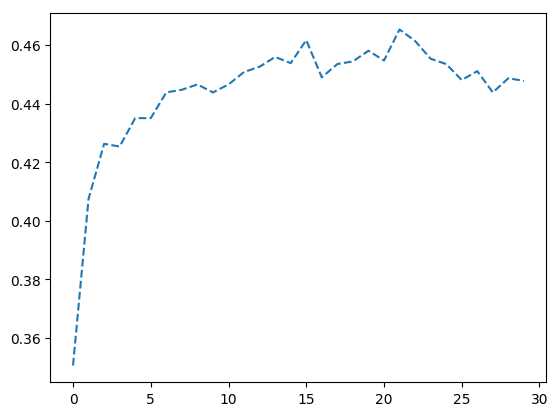

In [0]:
mean_acc_tree_lstm = np.mean([tree_lstm_accuracies_1, tree_lstm_accuracies_2, tree_lstm_accuracies_3], axis = 0)
plt.plot(mean_acc_tree_lstm, '--')

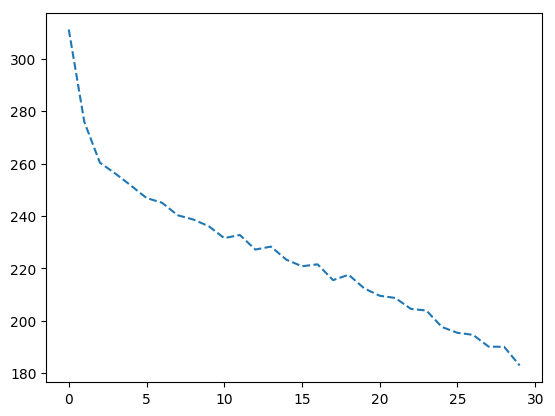

In [0]:
mean_loss_tree_lstm = np.mean([tree_lstm_losses_1, tree_lstm_losses_2, tree_lstm_losses_3], axis = 0)
plt.plot(mean_loss_tree_lstm, '--')

##EVALUATE OF TREE LSTMS ##

In [0]:
mean_accuracy_mb_lstm = np.mean([0.4615, 0.4588, 0.4783])
std_accuracy_mb_lstm = np.std([0.4615, 0.4588, 0.4783])
print('Mean accuracy of LSTMS:', mean_accuracy_mb_lstm,'STD of LSTMS:', std_accuracy_mb_lstm)

Mean accuracy of LSTMS: 0.4662 STD of LSTMS: 0.008626702730475881


## COMPARISON LSTMS w/ TREE LSTMS ##

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(mean_acc_tree_lstm, label='Tree LSTM')
ax.plot(mean_acc_mb_lstm, label='Mini-banch LSTM')

ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40, 0.45)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6);

NameError: ignored

## SUBTREE ##

In [0]:
torch.manual_seed(1231)
USE_SUBTREE_DATA = True
tree_model = TreeLSTMClassifier(len(glove_v.w2i), 300, 150, len(t2i), glove_v)
with torch.no_grad():
  tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  tree_model.embed.weight.requires_grad = False
sb_tree_lstm_losses_1, sb_tree_lstm_acc_1 = do_train(tree_model)
save_data(sb_tree_lstm_losses_1, 'sb_tree_lstm_losses_1.txt')
save_data(sb_tree_lstm_acc_1, 'sb_tree_lstm_acc_1.txt')

torch.manual_seed(1232)
tree_model = TreeLSTMClassifier(len(glove_v.w2i), 300, 150, len(t2i), glove_v)
with torch.no_grad():
  tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  tree_model.embed.weight.requires_grad = False
sb_tree_lstm_losses_2, sb_tree_lstm_acc_2 = do_train(tree_model)
save_data(sb_tree_lstm_losses_2, 'sb_tree_lstm_losses_2.txt')
save_data(sb_tree_lstm_acc_2, 'sb_tree_lstm_acc_2.txt')

torch.manual_seed(1233)
tree_model = TreeLSTMClassifier(len(glove_v.w2i), 300, 150, len(t2i), glove_v)
with torch.no_grad():
  tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  tree_model.embed.weight.requires_grad = False
sb_tree_lstm_losses_3, sb_tree_lstm_acc_3 = do_train(tree_model)
save_data(sb_tree_lstm_losses_3, 'sb_tree_lstm_losses_3.txt')
save_data(sb_tree_lstm_acc_3, 'sb_tree_lstm_acc_3.txt')

USE_SUBTREE_DATA = False

Shuffling training data
Iter 200: loss=311.4736, time=71.05s
iter 200: dev acc=0.3179
new highscore
Iter 400: loss=278.2502, time=148.46s
iter 400: dev acc=0.4087
new highscore
Iter 600: loss=261.0312, time=223.86s
iter 600: dev acc=0.4160
new highscore
Iter 800: loss=254.5148, time=299.93s
iter 800: dev acc=0.4105
Iter 1000: loss=249.3551, time=375.59s
iter 1000: dev acc=0.4187
new highscore
Iter 1200: loss=247.5833, time=450.46s
iter 1200: dev acc=0.4205
new highscore
Iter 1400: loss=244.6113, time=526.49s
iter 1400: dev acc=0.4287
new highscore
Iter 1600: loss=239.1718, time=602.78s
iter 1600: dev acc=0.4332
new highscore
Iter 1800: loss=237.9008, time=677.80s
iter 1800: dev acc=0.4287
Iter 2000: loss=231.0192, time=752.91s
iter 2000: dev acc=0.4432
new highscore
Iter 2200: loss=227.3718, time=828.35s
iter 2200: dev acc=0.4378
Iter 2400: loss=226.8779, time=904.08s
iter 2400: dev acc=0.4478
new highscore
Iter 2600: loss=216.3809, time=979.21s
iter 2600: dev acc=0.4460
Iter 2800: los

KeyboardInterrupt: ignored

In [0]:
plt.plot(results_subtree[0])

In [0]:
plt.plot(results_subtree[1])

## ANALYSIS SB##

In [0]:
sb = [0.4692, 0.4685, 0.4689]
print(np.mean(sb), np.std(sb))

0.4688666666666667 0.0002867441755680775


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


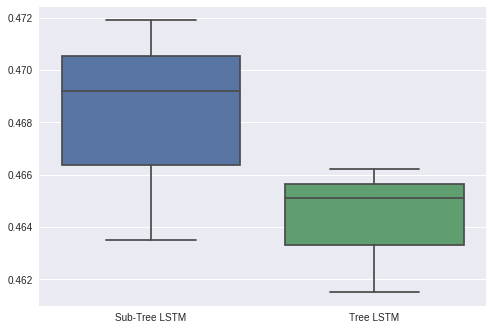

In [0]:
# library & dataset
import seaborn as sns
import pandas as pd


# library & dataset
import seaborn as sns
d = {'Tree LSTM': [0.4615, 0.4662, 0.4651], 'Sub-Tree LSTM': [0.4692, 0.4635, 0.4719]}
df = pd.DataFrame(data=d)
sns.boxplot(data=df.ix[:,0:2])
#sns.plt.show()



# PART 2 #

## LOAD MODEL DATA ##

In [0]:
# Load Data

    # BOW
with open('/gdrive/My Drive/nlp_data/bow_losses_1.txt', 'r') as f:
     bow_losses_1 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/bow_accuracies_1.txt', 'r') as f:
     bow_accuracies_1 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/bow_losses_2.txt', 'r') as f:
     bow_losses_2 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/bow_accuracies_2.txt', 'r') as f:
     bow_accuracies_2 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/bow_losses_3.txt', 'r') as f:
     bow_losses_3 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/bow_accuracies_3.txt', 'r') as f:
     bow_accuracies_3 = eval(f.read())
    
    # cBOW
with open('/gdrive/My Drive/nlp_data/cbow_losses_1.txt', 'r') as f:
     cbow_losses_1 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/cbow_accuracies_1.txt', 'r') as f:
     cbow_accuracies_1 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/cbow_losses_2.txt', 'r') as f:
     cbow_losses_2 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/cbow_accuracies_2.txt', 'r') as f:
     cbow_accuracies_2 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/cbow_losses_3.txt', 'r') as f:
     cbow_losses_3 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/cbow_accuracies_3.txt', 'r') as f:
     cbow_accuracies_3 = eval(f.read())
    
    # Deep cBOW
with open('/gdrive/My Drive/nlp_data/deep_cbow_losses_1.txt', 'r') as f:
     deep_cbow_losses_1 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/deep_cbow_accuracies_1.txt', 'r') as f:
     deep_cbow_accuracies_1 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/deep_cbow_losses_2.txt', 'r') as f:
     deep_cbow_losses_2 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/deep_cbow_accuracies_2.txt', 'r') as f:
     deep_cbow_accuracies_2 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/deep_cbow_losses_3.txt', 'r') as f:
     deep_cbow_losses_3 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/deep_cbow_accuracies_3.txt', 'r') as f:
     deep_cbow_accuracies_3 = eval(f.read())
    
    # pt Deep cBOW
with open('/gdrive/My Drive/nlp_data/pt_deep_cbow_losses_1.txt', 'r') as f:
     pt_deep_cbow_losses_1 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/pt_deep_cbow_accuracies_1.txt', 'r') as f:
     pt_deep_cbow_accuracies_1 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/pt_deep_cbow_losses_2.txt', 'r') as f:
     pt_deep_cbow_losses_2 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/pt_deep_cbow_accuracies_2.txt', 'r') as f:
     pt_deep_cbow_accuracies_2 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/pt_deep_cbow_losses_3.txt', 'r') as f:
     pt_deep_cbow_losses_3 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/pt_deep_cbow_accuracies_3.txt', 'r') as f:
     pt_deep_cbow_accuracies_3 = eval(f.read())
    
    # LSTM
with open('/gdrive/My Drive/nlp_data/lstm_losses_1.txt', 'r') as f:
     lstm_losses_1 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/lstm_accuracies_1.txt', 'r') as f:
     lstm_accuracies_1 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/lstm_losses_2.txt', 'r') as f:
     lstm_losses_2 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/lstm_accuracies_2.txt', 'r') as f:
     lstm_accuracies_2 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/lstm_losses_3.txt', 'r') as f:
     lstm_losses_3 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/lstm_accuracies_3.txt', 'r') as f:
     lstm_accuracies_3 = eval(f.read())
    
    # mb LSTM
with open('/gdrive/My Drive/nlp_data/mb_lstm_losses_1.txt', 'r') as f:
     mb_lstm_losses_1 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/mb_lstm_accuracies_1.txt', 'r') as f:
     mb_lstm_accuracies_1 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/mb_lstm_losses_2.txt', 'r') as f:
     mb_lstm_losses_2 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/mb_lstm_accuracies_2.txt', 'r') as f:
     mb_lstm_accuracies_2 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/mb_lstm_losses_3.txt', 'r') as f:
     mb_lstm_losses_3 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/mb_lstm_accuracies_3.txt', 'r') as f:
     mb_lstm_accuracies_3 = eval(f.read())
    
    # Tree LSTM
with open('/gdrive/My Drive/nlp_data/tree_lstm_losses_1.txt', 'r') as f:
     tree_lstm_losses_1 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/tree_lstm_accuracies_1.txt', 'r') as f:
     tree_lstm_accuracies_1 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/tree_lstm_losses_2.txt', 'r') as f:
     tree_lstm_losses_2 = eval(f.read())    
with open('/gdrive/My Drive/nlp_data/tree_lstm_accuracies_2.txt', 'r') as f:
     tree_lstm_accuracies_2 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/tree_lstm_losses_3.txt', 'r') as f:
     tree_lstm_losses_3 = eval(f.read())   
with open('/gdrive/My Drive/nlp_data/tree_lstm_accuracies_3.txt', 'r') as f:
     tree_lstm_accuracies_3 = eval(f.read())

In [0]:
mean_acc_bow = np.mean([bow_accuracies_1, bow_accuracies_2, bow_accuracies_3], axis = 0)
mean_acc_cbow = np.mean([cbow_accuracies_1, cbow_accuracies_2, cbow_accuracies_3], axis = 0)
mean_acc_deep_bow = np.mean([deep_cbow_accuracies_1, deep_cbow_accuracies_2, deep_cbow_accuracies_3], axis = 0)
mean_acc_pt_deep_bow = np.mean([pt_deep_cbow_accuracies_1, pt_deep_cbow_accuracies_2, pt_deep_cbow_accuracies_3], axis = 0)
mean_acc_lstm = np.mean([lstm_accuracies_1, lstm_accuracies_2, lstm_accuracies_3], axis = 0)
mean_acc_mb_lstm = np.mean([mb_lstm_accuracies_1, mb_lstm_accuracies_2, mb_lstm_accuracies_3], axis = 0)
mean_acc_tree_lstm = np.mean([tree_lstm_accuracies_1, tree_lstm_accuracies_2, tree_lstm_accuracies_3], axis = 0)


## VISUAL OF ALL MODELS ##

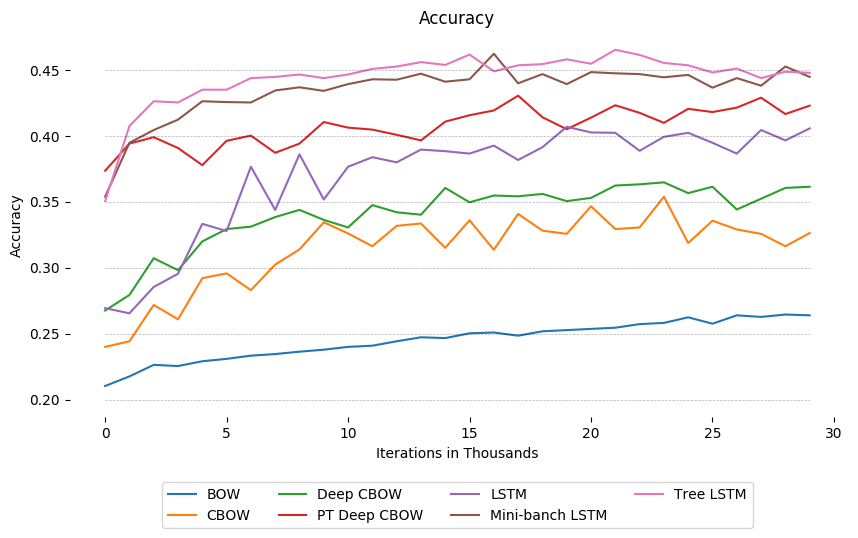

In [0]:
# Accuracies

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(mean_acc_bow, label='BOW')
ax.plot(mean_acc_cbow, label='CBOW')
ax.plot(mean_acc_deep_bow, label='Deep CBOW')
ax.plot(mean_acc_pt_deep_bow, label='PT Deep CBOW')
ax.plot(mean_acc_lstm, label='LSTM')
ax.plot(mean_acc_mb_lstm, label='Mini-banch LSTM')
ax.plot(mean_acc_tree_lstm, label='Tree LSTM')


ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
g = (0.20, 0.25, 0.30, 0.35, 0.40, 0.45)
for y in g:    
    ax.plot(range(0, 30), y * np.ones(30) , "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4);

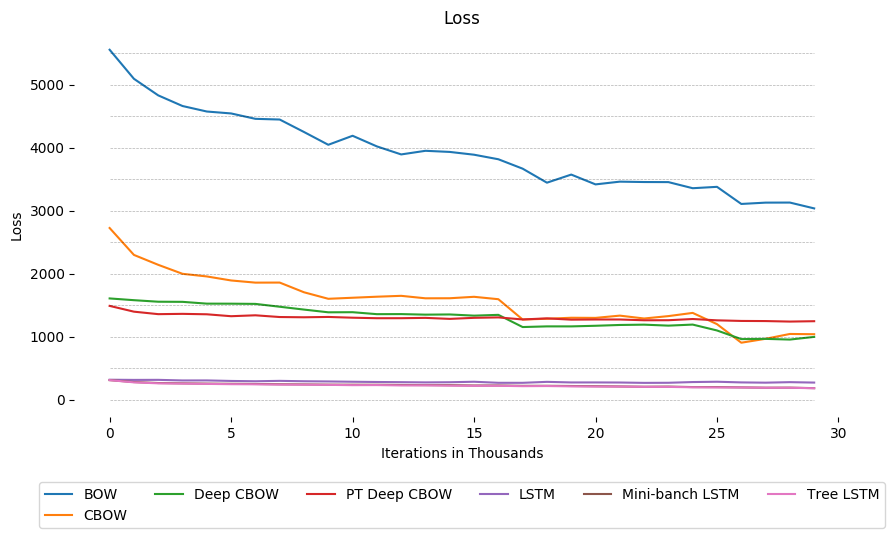

In [0]:
# Losses

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(mean_loss_bow, label='BOW')
ax.plot(mean_loss_cbow, label='CBOW')
ax.plot(mean_loss_deep_bow, label='Deep CBOW')
ax.plot(mean_loss_pt_deep_bow, label='PT Deep CBOW')
ax.plot(mean_loss_lstm, label='LSTM')
ax.plot(mean_loss_mb_lstm, label='Mini-banch LSTM')
ax.plot(mean_loss_tree_lstm, label='Tree LSTM')


ax.set_xlabel('Iterations in Thousands')
ax.set_ylabel('Loss')
ax.set_title('Loss')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
for y in range(0, 6000, 500):    
    plt.plot(range(0, 30), [y] * len(range(0, 30)), "--", lw=0.5, color="black", alpha=0.3) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6);

## Sign Test##

In [0]:
def predict(model, data, prep_fn=prepare_example):
  """
  predicts the sentiment for one specific, given review in the test _data
  """
  model.eval()  # disable dropout
  for example in data:
    # convert the example input and label to PyTorch tensors
    x, target = prep_fn(example, model.vocab)

    # forward pass
    # get the output from the neural network for input x
    with torch.no_grad():
      logits = model(x)
    
    # get out the prediction
    prediction = logits.argmax(dim=-1)
    
  return prediction

In [0]:
from decimal import *
import scipy

def sign_test(model_input):
  ties, plus, minus = 0, 0, 0
###
  models = model_input
  for sample_review in test_data:
  
    predictionlist = []
  
    for r, model in enumerate(models):
      prediction = None
      # Move mode to device
      model.to(device)

      # Set up variables according to the model
      if model._class.name_ == 'TreeLSTMClassifier' or model._class.name_ == 'GloveTreeLSTMClassifier' or model._class.name_ == 'GloveSubTreeLSTMClassifier' or model._class.name_ == 'SUBTreeLSTMClassifier':
        prep_fn = prepare_treelstm_minibatch
        prediction = predict(model, [[sample_review]], prep_fn)
      else:
        prep_fn = prepare_example
        prediction = predict(model, [sample_review], prep_fn)
      predictionlist.append(prediction)

    if predictionlist[0] == predictionlist[1] == sample_review.label:
      ties += 1
    elif predictionlist[0] == sample_review.label: 
      plus += 1
    elif predictionlist[1] == sample_review.label: 
      minus += 1
      
  N = 2 * math.ceil(ties / 2) + plus + minus
  k = math.ceil(ties / 2) + min(plus, minus)
  p_value = Decimal(0.0)
  for i in range(0, k + 1):
      p_value += 2* Decimal(scipy.special.comb(N, i, exact=True)) * (Decimal(0.5) ** Decimal(N))

  
  print(models[0]._class.name_)
  print(models[1]._class.name_)
  # Use two-tailed version of test
  print("p_value =", p_value)
  print("The difference is", "not significant" if p_value >= 0.05 else "significant")

------------ /////// ----------


In [0]:
from scipy import stats
#ttest_ind
_,p_value_bow_cbow = stats.ttest_ind(mean_acc_bow,mean_acc_cbow)
_,p_value_cbow_deep_cbow = stats.ttest_ind(mean_acc_deep_bow,mean_acc_cbow)
_,p_value_deep_cbow_pt_deep_bow = stats.ttest_ind(mean_acc_deep_bow,mean_acc_pt_deep_bow)

_,p_value_pt_deep_bow_lstm= stats.ttest_ind(mean_acc_lstm,mean_acc_pt_deep_bow)
_,p_value_lstm_mb_lstm= stats.ttest_ind(mean_acc_lstm,mean_acc_mb_lstm)
_,p_value_mb_lstm_tree_lstm = stats.ttest_ind(mean_acc_mb_lstm,mean_acc_tree_lstm)


print("%.10f" %p_value_bow_cbow)
print("%.10f" %p_value_cbow_deep_cbow)
print("%.10f" %p_value_deep_cbow_pt_deep_bow)
print("%.10f" %p_value_pt_deep_bow_lstm)
print("%.10f" %p_value_lstm_mb_lstm)
print("%.10f" %p_value_mb_lstm_tree_lstm)

[0.21041477 0.2176809  0.22646079 0.22555253 0.22918559 0.23100212
 0.23342416 0.23463518 0.23645171 0.23796549 0.24008477 0.24099304
 0.24432334 0.24735089 0.24674538 0.25037844 0.25098395 0.24856191
 0.25189222 0.25280048 0.25370875 0.25461701 0.25734181 0.25825008
 0.26248865 0.25764457 0.26400242 0.2627914  0.26460793 0.26400242]
0.0000000000
0.0002785911
0.0000000000
0.0000192333
0.0000000003
0.0871298210


In [0]:
from scipy import stats
#wilcoxon

_,p_value_bow_cbow = stats.wilcoxon(mean_acc_bow,mean_acc_cbow)
_,p_value_cbow_deep_cbow = stats.wilcoxon(mean_acc_deep_bow,mean_acc_cbow)
_,p_value_deep_cbow_pt_deep_bow = stats.wilcoxon(mean_acc_deep_bow,mean_acc_pt_deep_bow)

_,p_value_pt_deep_bow_lstm= stats.wilcoxon(mean_acc_lstm,mean_acc_pt_deep_bow)
_,p_value_lstm_mb_lstm= stats.wilcoxon(mean_acc_lstm,mean_acc_mb_lstm)
_,p_value_mb_lstm_tree_lstm = stats.wilcoxon(mean_acc_mb_lstm,mean_acc_tree_lstm)


print("%.10f" %p_value_bow_cbow)
print("%.10f" %p_value_cbow_deep_cbow)
print("%.10f" %p_value_deep_cbow_pt_deep_bow)
print("%.10f" %p_value_pt_deep_bow_lstm)
print("%.10f" %p_value_lstm_mb_lstm)
print("%.10f" %p_value_mb_lstm_tree_lstm)

0.0000017344
0.0000017344
0.0000017333
0.0000019197
0.0000017322
0.0000259416


In [0]:
from scipy import stats
#ttest_ind

_,p_value_bow_cbow = stats.ttest_ind(mean_acc_bow,mean_acc_cbow)
_,p_value_cbow_deep_cbow = stats.ttest_ind(mean_acc_deep_bow,mean_acc_cbow)
_,p_value_deep_cbow_pt_deep_bow = stats.ttest_ind(mean_acc_deep_bow,mean_acc_pt_deep_bow)

_,p_value_pt_deep_bow_lstm= stats.ttest_ind(mean_acc_lstm,mean_acc_pt_deep_bow)
_,p_value_lstm_mb_lstm= stats.ttest_ind(mean_acc_lstm,mean_acc_mb_lstm)
_,p_value_mb_lstm_tree_lstm = stats.ttest_ind(mean_acc_mb_lstm,mean_acc_tree_lstm)


print(p_value_bow_cbow)
print(p_value_cbow_deep_cbow)
print(p_value_deep_cbow_pt_deep_bow)
print(p_value_pt_deep_bow_lstm)
print(p_value_lstm_mb_lstm)
print(p_value_mb_lstm_tree_lstm)

In [0]:
from scipy import stats

_,p_value = stats.ttest_ind([0.4615, 0.4662, 0.4651],[0.4692, 0.4635, 0.4719])
print(p_value)

0.24019563350893236


##Sentence lengh##

##Statistical Relevance##

In [0]:
mean_accuracy_bow = [0.2616, 0.2752, 0.2616]
mean_accuracy_cbow = [0.3421, 0.3638, 0.3552]
mean_accuracy_deep_cbow = [0.3842, 0.3751, 0.3688]
mean_accuracy_pt_deep_cbow = [0.4332, 0.4523, 0.4296]
mean_accuracy_lstm = [0.4222, 0.4269, 0.4254]
mean_accuracy_mb_lstm = [0.4615, 0.4588, 0.4783]
mean_accuracy_mb_lstm = [0.4615, 0.4588, 0.4783]
mean_accuracy_mb_lstm_sb = [0.4692, 0.4685, 0.4689]


In [0]:
from scipy import stats
#ttest_ind

_,p_value_bow_cbow = stats.ttest_ind(mean_accuracy_bow,mean_accuracy_cbow)
_,p_value_cbow_deep_cbow = stats.ttest_ind(mean_accuracy_cbow,mean_accuracy_deep_cbow)
_,p_value_deep_cbow_pt_deep_bow = stats.ttest_ind(mean_accuracy_deep_cbow,mean_accuracy_pt_deep_cbow)

_,p_value_pt_deep_bow_lstm= stats.ttest_ind(mean_accuracy_pt_deep_cbow,mean_accuracy_lstm)
_,p_value_lstm_mb_lstm= stats.ttest_ind(mean_accuracy_lstm,mean_accuracy_mb_lstm)
_,p_value_mb_lstm_tree_lstm = stats.ttest_ind(mean_accuracy_mb_lstm,mean_accuracy_mb_lstm)
_,p_value_tree_lstm_sb_lstm = stats.ttest_ind(mean_accuracy_mb_lstm,mean_accuracy_mb_lstm_sb)


print(p_value_bow_cbow)
print(p_value_cbow_deep_cbow)
print(p_value_deep_cbow_pt_deep_bow)
print(p_value_pt_deep_bow_lstm)
print(p_value_lstm_mb_lstm)
print(p_value_mb_lstm_tree_lstm)
print(p_value_tree_lstm_sb_lstm)


0.0003529899994021893
0.04463395908528393
0.0017150384778891541
0.1324869583001122
0.0027109667873062454
1.0
0.6847230308108634


In [0]:
from scipy import stats
#kruskal

_,p_value_bow_cbow = stats.kstest(mean_accuracy_bow,mean_accuracy_cbow)
_,p_value_cbow_deep_cbow = stats.kstest(mean_accuracy_cbow,mean_accuracy_deep_cbow)
_,p_value_deep_cbow_pt_deep_bow = stats.kstest(mean_accuracy_deep_cbow,mean_accuracy_pt_deep_cbow)

_,p_value_pt_deep_bow_lstm= stats.kstest(mean_accuracy_pt_deep_cbow,mean_accuracy_lstm)
_,p_value_lstm_mb_lstm= stats.kstest(mean_accuracy_lstm,mean_accuracy_mb_lstm)
_,p_value_mb_lstm_tree_lstm = stats.kstest(mean_accuracy_mb_lstm,mean_accuracy_mb_lstm)


print(p_value_bow_cbow)
print(p_value_cbow_deep_cbow)
print(p_value_deep_cbow_pt_deep_bow)
print(p_value_pt_deep_bow_lstm)
print(p_value_lstm_mb_lstm)
print(p_value_mb_lstm_tree_lstm)

TypeError: ignored


# Further experiments and report

For your report, you are expected to answer research questions by doing further experiments.

## Research Questions

Make sure you cover at least the following:

- How important is word order for this task?
- Does the tree structure help to get a better accuracy?
- How does performance depend on the sentence length? Compare the various models. Is there a model that does better on longer sentences? If so, why?
- Do you get better performance if you supervise the sentiment **at each node in the tree**? You can extract more training examples by treating every node in each tree as a separate tree. You will need to write a function that extracts all subtrees given a treestring. 
    - Warning: NLTK's Tree function seems to result in invalid trees in some cases, so be careful if you want to parse the string to a tree structure before extraction the phrases.

Optionally, you can also investigate the following:

- When making a wrong prediction, can you figure out at what point in the tree (sentence) the model fails? You can make a prediction at each node to investigate.
- How does N-ary Tree LSTM compare to the Child-Sum Tree LSTM? 
- How do the Tai et al. Tree LSTMs compare to Le & Zuidema's formulation?
- Or.. your own research question!

In general:

- ***When you report numbers, please report the mean accuracy across 3 (or more) runs with different random seed, together with the standard deviation.*** This is because the final performance may vary per random seed.

## Report instructions

Your report needs to be written in LaTeX. You are required to use the ACL 2018 template [(zip)](https://acl2018.org/downloads/acl18-latex.zip) which you can edit directly on [Overleaf](https://www.overleaf.com/latex/templates/instructions-for-acl-2018-proceedings/xzmhqgnmkppc). Make sure your names and student numbers are visible at the top. (Tip: you need to uncomment `/aclfinalcopy`).
You can find some general tips about writing a research paper [here](https://www.microsoft.com/en-us/research/academic-program/write-great-research-paper/), but note that you need to make your own judgment about what is appropriate for this project. 

We expect you to use the following structure:
1. Introduction (~1 page) - describe the problem, your research questions and goals, a summary of your findings and contributions. Please cite related work (models, data set) as part of your introduction here, since this is a short paper.
    - Introduce the task and the main goal
    - Clear research questions
    - Motivating the importance of the questions and explaining the expectations
    - How are these addressed or not addressed in the literature
    - What is your approach
    - Short summary of your findings
2. Background (~1/2-1 page) -
cover the main techniques ("building blocks") used in your project (e.g. word embeddings, LSTM, Tree LSTM) and intuitions behind them. Be accurate and concise.
    - How each technique that you use works (don't just copy the formulas)
    - The relation between the techniques
3. Models (~1/2 page) - Cover the models that you used.
    - The architecture of the final models (how do you use LSTM or Tree LSTM for the sentiment classification task. what layers you have, how do you do classification? What is your loss function?)
4. Experiments (~1/2 page) - Describe your experimental setup. The information here should allow someone else to re-create your experiments. Describe how you evaluate the models.
    - Explain the task and the data
    - Training the models (model, data, parameters and hyper parameters if the models, training algorithms, what supervision signals you use, etc.)
    - Evaluation (e.g. metrics)
5. Results and Analysis (~1 page). Go over the results and analyse your findings.
    - Answer each of the research questions you raised in the introduction.
    - Plots and figures highlighting interesting patterns
    - What are the factors that makes model A  better than model B in task C? investigate to prove their effect!
6. Conclusion (~1/4 page). The main conclusions of your experiments.
    - What you learned from you experiments? how does it relate to what is already known in the literature?
    - Where the results as expected ? any surprising results? why?
    - Based on what you learned what would you suggest to do next?


General Tips:

- Math notation – define each variable (either in running text, or in a pseudo-legenda after or before the equation)
- Define technical terminology you need
- Avoid colloquial language – everything can be said in a scientific-sounding way
- Avoid lengthy sentences, stay to the point!
- Do not spend space on "obvious" things!


An ideal report:
- Precise, scientific-sounding, technical, to the point 
  - Little general “waffle”/chit-chat
- Not boring – because you don’t explain obvious things too much
- Efficient delivery of (only) the facts that we need to know to understand/reimplement
- Results visually well-presented and described with the correct priority of importance of sub-results
- Insightful analysis – speculation should connect to something interesting and not be too much; the reader “learns something new”
- No typos, no colloquialisms – well-considered language
- This normally means several re-draftings (re-orderings of information)